In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 1000, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd.csv', encoding='cp1252')     

In [6]:
data.columns.values

array(['Name', 'Coef_a', 'Coef_b', 'Coef_c', 'Coef_d', 'A_site', 'B_site',
       'X_site', 'Spacegroup', 'Ehull', 'BulkModulus', 'Energy', 'ZPE',
       's_A', 's_B', 's_X', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [7]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup', 'Ehull','BulkModulus', 'Energy','s_A','s_B','s_X','ZPE', 'Coef_c', 'Coef_d'], axis=1, inplace = True)

In [8]:
data.fillna(0, inplace= True)
#sg_dummies = pd.get_dummies(data.Spacegroup)
#d = pd.concat([data, sg_dummies], axis=1)
#d.drop(['Spacegroup'], axis=1, inplace=True)

In [9]:
d=data.copy()
d.columns.values

array(['Coef_a', 'Coef_b', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [10]:
columns = list(d.columns.values)

# Standard Scaling

In [11]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data['Coef_a']).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data['Coef_a']).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std['Coef_a'] 
X = data_std.drop(['Coef_a'], axis=1)

In [12]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [13]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'A_Rc', 'B_Hv', 'X_Hv', 'A_MendeleevNo', 'A_MV', 'A_Ra', 'X_Hf', 'X_Rc', 'A_M', 'X_CvM', 'B_M', 'X_Ra', 'X_M', 'X_BP', 'A_Hf', 'A_BP', 'B_BP', 'X_ChiA', 'X_MP', 'X_IEII', 'A_Hv', 'X_MendeleevNo', 'X_B'}


In [14]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape

(80, 52)

### Test-train splitting 

In [15]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('Coef_a')
X = df_train

Y_test = df_test.pop('Coef_a')
X_test = df_test

RF 0.9886743011700898
RMSE:  0.10630253189569192
RMSE unscaled:  3.0508654710299926e-09
----------------------------------------


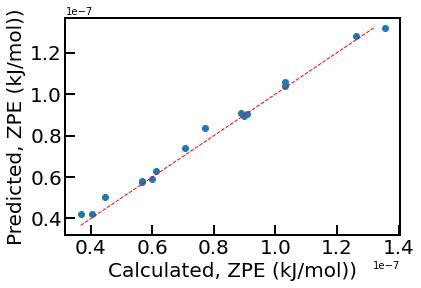

GB 0.9669365640935079
RMSE:  0.18162895976341695
RMSE unscaled:  5.21272176682521e-09
----------------------------------------


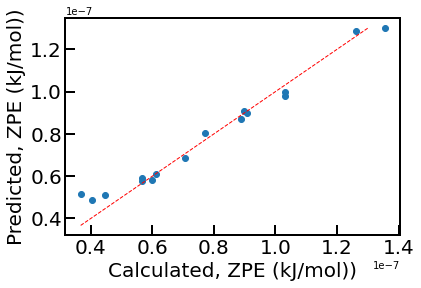

LR 0.9692843155013058
RMSE:  0.17506172486314822
RMSE unscaled:  5.02424318743415e-09
----------------------------------------


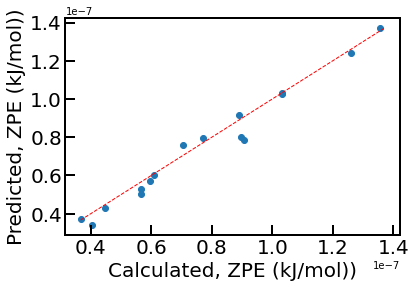

RR 0.9674891867224901
RMSE:  0.18010468954886444
RMSE unscaled:  5.168975458217425e-09
----------------------------------------


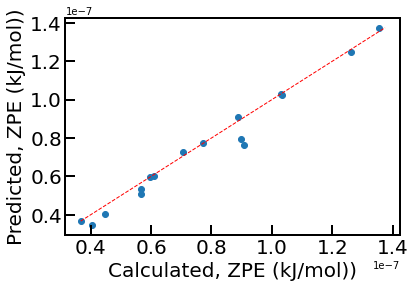

LASSO 0.9974772394232632
RMSE:  0.05017058003195637
RMSE unscaled:  1.4398875318532802e-09
----------------------------------------


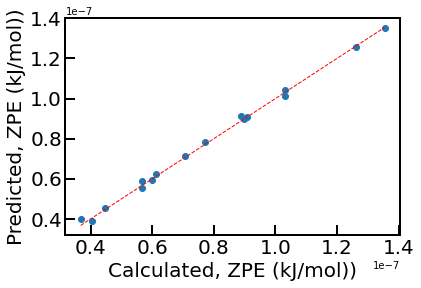

gpr1 0.9693856148272731
RMSE:  0.17477281253027557
RMSE unscaled:  5.015951450212117e-09
----------------------------------------


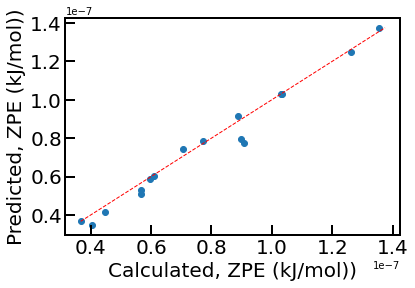

gpr2 0.9819218686650576
RMSE:  0.1343036676366552
RMSE unscaled:  3.854493537627252e-09
----------------------------------------


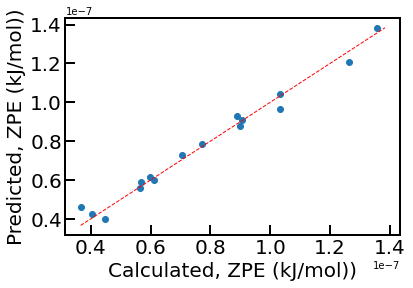

gpr3 0.9819218713781414
RMSE:  0.1343036575588127
RMSE unscaled:  3.854493248394803e-09
----------------------------------------


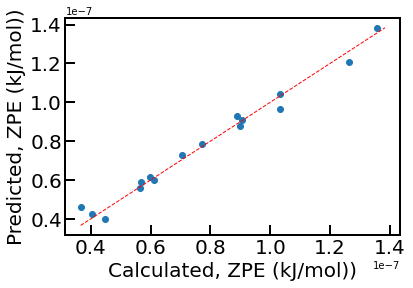

gpr4 0.9749997819575368
RMSE:  0.15793667926849753
RMSE unscaled:  4.532757148834428e-09
----------------------------------------


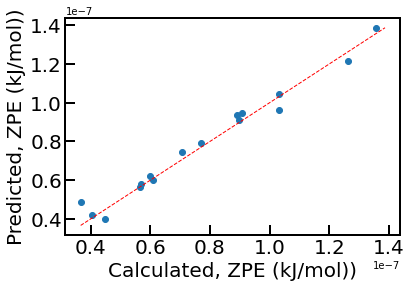

gpr5 0.9819209773639577
RMSE:  0.13430697836410424
RMSE unscaled:  3.854588554969533e-09
----------------------------------------


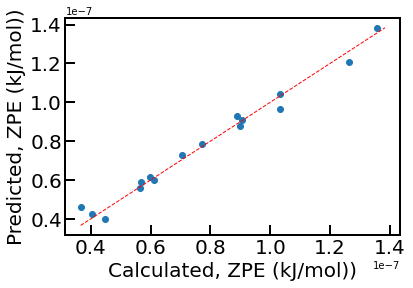

gpr6 0.8710866615507444
RMSE:  0.35864107853404575
RMSE unscaled:  1.0292940943928903e-08
----------------------------------------


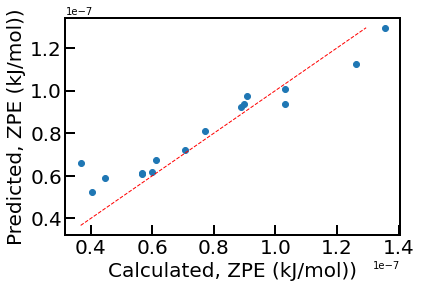

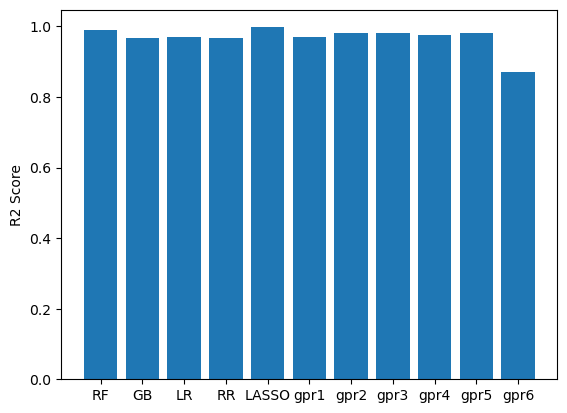

In [16]:
run_models()

In [17]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature        Score
0     Coef_b  3230.667638
2   mean_A2B   109.296724
26      X_EA    73.368669
15       X_Z    66.718735
5   mean_X2X    56.945060
33    X_Rvdw    56.130242
31    A_Rvdw    51.699207
3   mean_A2X    40.526215
19     A_IEI    32.506577
10     E_coh    30.740923
30    A_ChiA    16.249435
7    std_A2X    15.249756
27    A_ChiP    14.642045
24      A_EA    13.518905
42      B_Hf    13.440569
45   X_Kappa    12.439648
37      B_MP    11.182324
36      A_MP    10.204076
43   A_Kappa     8.683247
8    std_B2X     8.580932
13       A_Z     8.474870
44   B_Kappa     8.031022
14       B_Z     6.255140
18       X_G     6.249672
46     A_CvM     5.656104
16       A_G     5.063472
12        OF     4.732281
35      B_Ra     4.706026
21     X_IEI     4.443059
48       A_B     4.300002


In [18]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['Coef_b', 'mean_A2B', 'X_EA', 'X_Z', 'mean_X2X', 'X_Rvdw',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_MP', 'A_Kappa',
       'std_B2X', 'A_Z', 'B_Kappa', 'B_Z', 'X_G', 'A_CvM', 'A_G', 'OF',
       'B_Ra', 'X_IEI', 'A_B', 'std_A2B', 'B_EA', 'B_Rho', 'X_MV',
       'density', 'B_IEI', 'B_ChiP', 'B_CvM', 'std_X2X', 'A_Rho'],
      dtype=object)

In [19]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9880234632022655
RMSE:  0.1093142377529229
RMSE unscaled:  3.137300941990747e-09
----------------------------------------


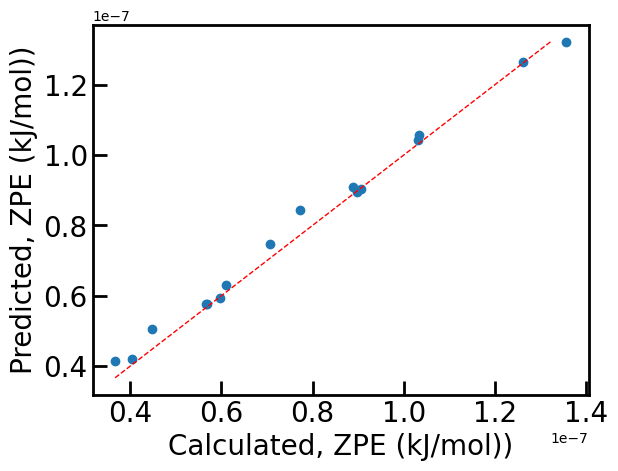

GB 0.9619073472352866
RMSE:  0.19495380375350693
RMSE unscaled:  5.595142634054569e-09
----------------------------------------


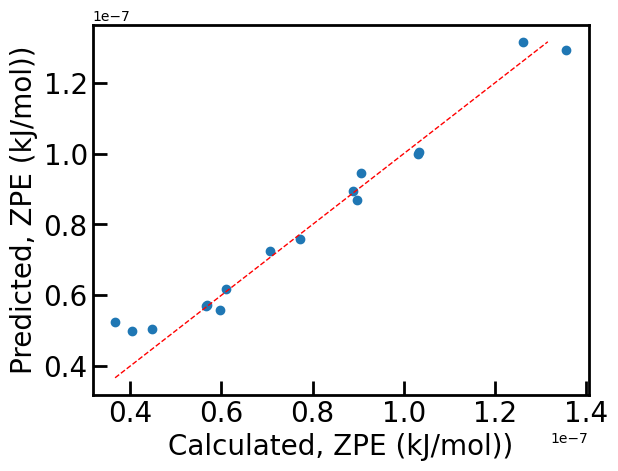

LR 0.987336158497157
RMSE:  0.11240712428594073
RMSE unscaled:  3.2260662852156506e-09
----------------------------------------


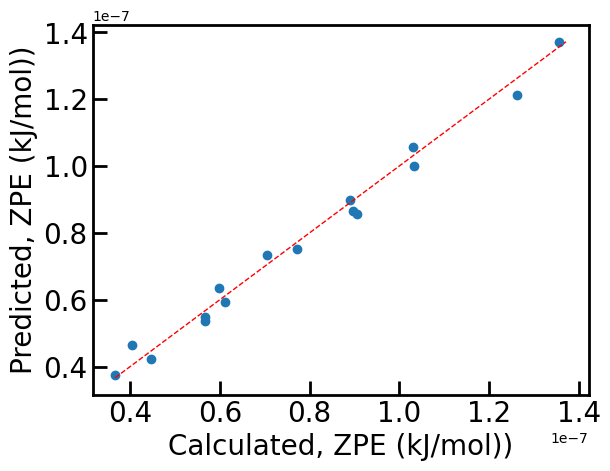

RR 0.9875998971001025
RMSE:  0.11123046396193473
RMSE unscaled:  3.1922963242408445e-09
----------------------------------------


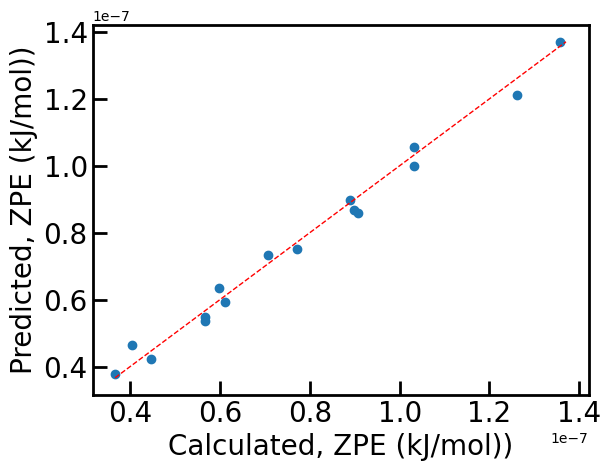

LASSO 0.9982665605776069
RMSE:  0.041587751359923715
RMSE unscaled:  1.1935617372337836e-09
----------------------------------------


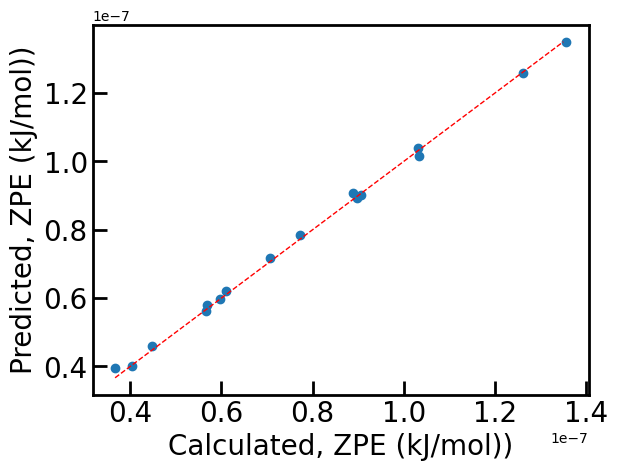

gpr1 0.9876989293047316
RMSE:  0.11078540799059679
RMSE unscaled:  3.179523289851006e-09
----------------------------------------


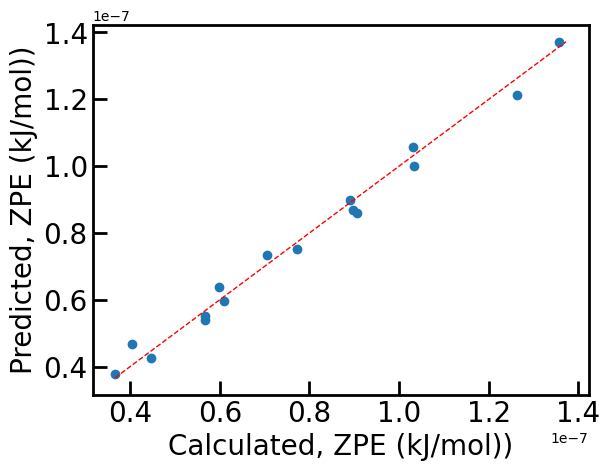

gpr2 0.9880345022484067
RMSE:  0.10926384743018214
RMSE unscaled:  3.1358547478786944e-09
----------------------------------------


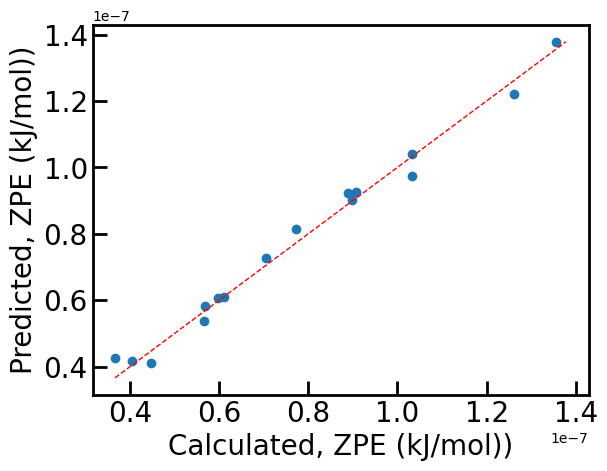

gpr3 0.9880344813324264
RMSE:  0.10926394292806796
RMSE unscaled:  3.1358574886525693e-09
----------------------------------------


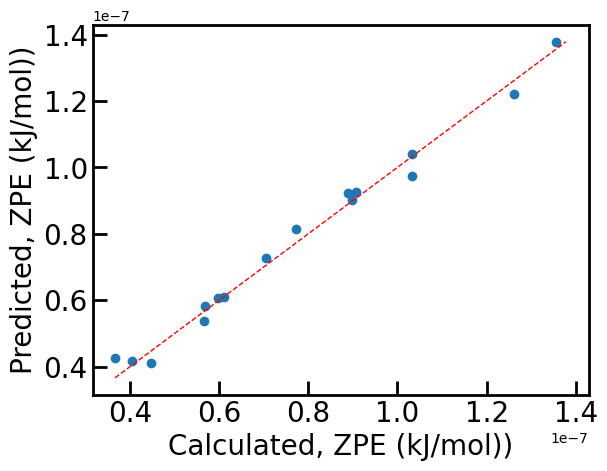

gpr4 0.9800027895636467
RMSE:  0.14125239252788543
RMSE unscaled:  4.0539208180531125e-09
----------------------------------------


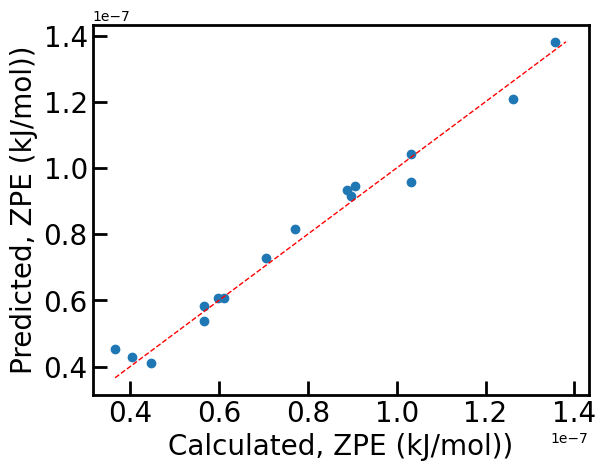

gpr5 0.9880345121479177
RMSE:  0.10926380223110606
RMSE unscaled:  3.1358534506725197e-09
----------------------------------------


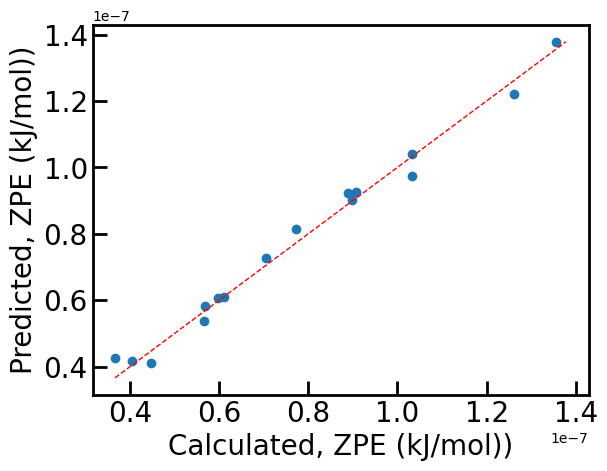

gpr6 0.9051922517259977
RMSE:  0.30756224351456096
RMSE unscaled:  8.826986640843303e-09
----------------------------------------


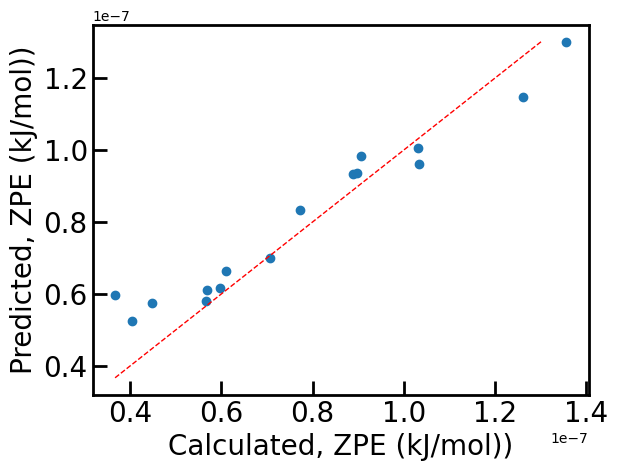

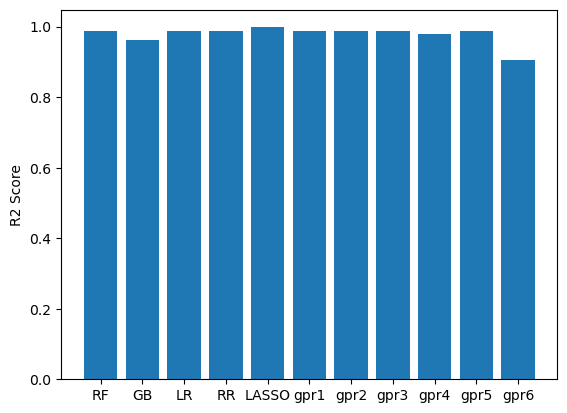

In [20]:
run_models()

In [21]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['Coef_b', 'mean_A2B', 'X_EA', 'X_Z', 'mean_X2X', 'X_Rvdw',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_MP', 'A_Kappa',
       'std_B2X', 'A_Z', 'B_Kappa', 'B_Z', 'X_G', 'A_CvM', 'A_G', 'OF',
       'B_Ra', 'X_IEI', 'A_B'], dtype=object)

In [22]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9894823462847732
RMSE:  0.10244022841704417
RMSE unscaled:  2.9400179859182755e-09
----------------------------------------


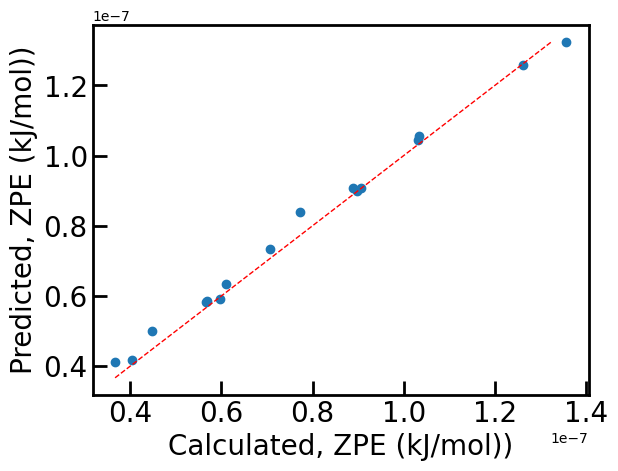

GB 0.9593968752718287
RMSE:  0.2012754622935464
RMSE unscaled:  5.77657321162889e-09
----------------------------------------


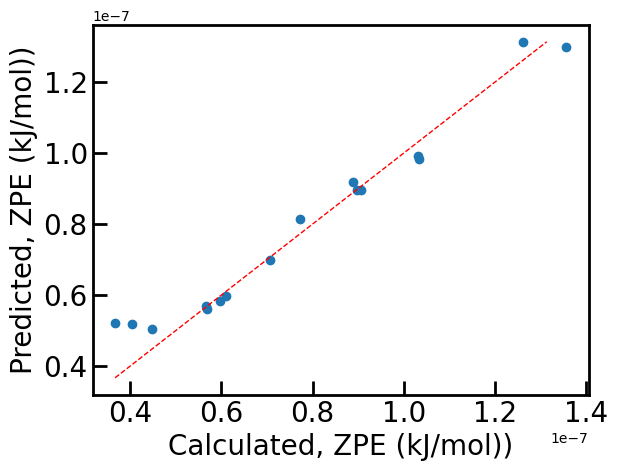

LR 0.9908495620351888
RMSE:  0.09555029775335598
RMSE unscaled:  2.742278090312941e-09
----------------------------------------


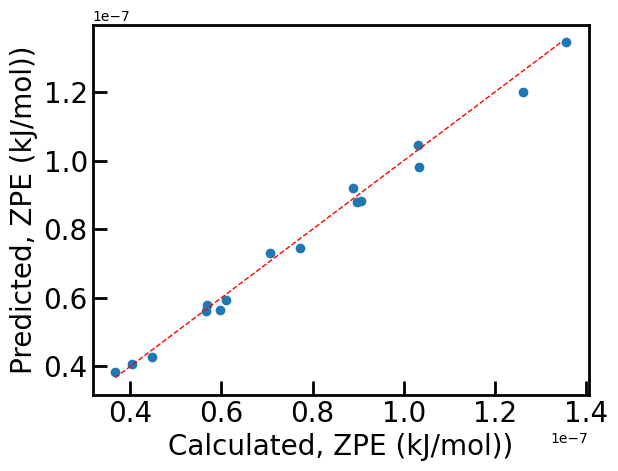

RR 0.9909074193877243
RMSE:  0.09524774099437107
RMSE unscaled:  2.733594760268463e-09
----------------------------------------


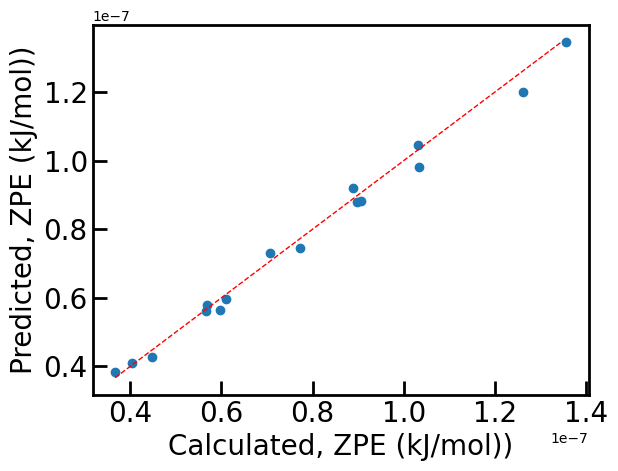

LASSO 0.9984438591359223
RMSE:  0.039403568802580335
RMSE unscaled:  1.1308760511283632e-09
----------------------------------------


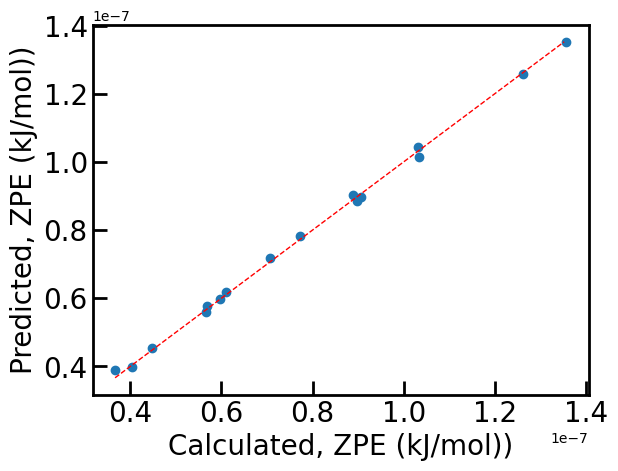

gpr1 0.9916003773174245
RMSE:  0.09154634148251184
RMSE unscaled:  2.6273651929774495e-09
----------------------------------------


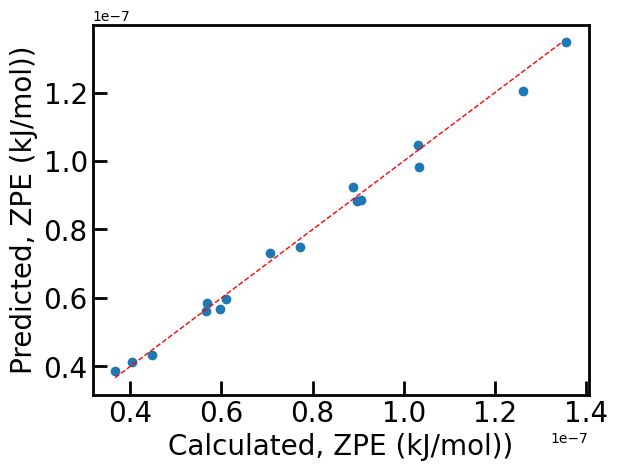

gpr2 0.9906245887882306
RMSE:  0.09671776828398611
RMSE unscaled:  2.775784305704302e-09
----------------------------------------


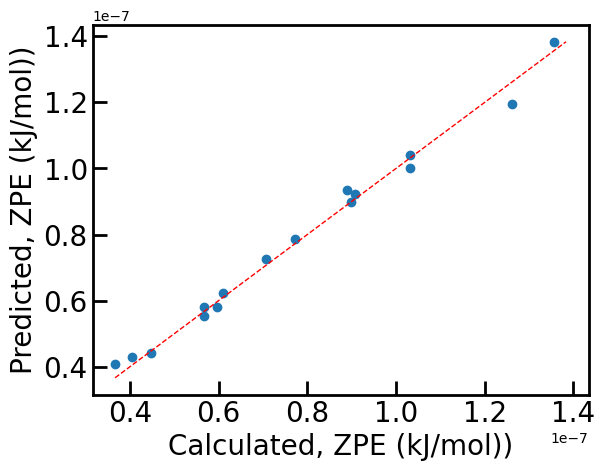

gpr3 0.9843908167481126
RMSE:  0.12479615183903511
RMSE unscaled:  3.581629372071036e-09
----------------------------------------


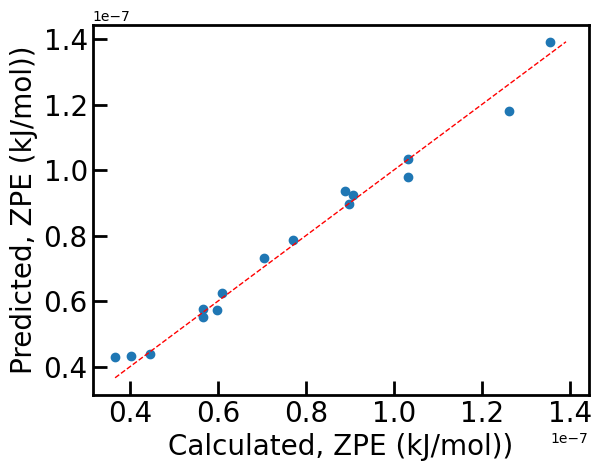

gpr4 0.9843908169291393
RMSE:  0.12479615111537609
RMSE unscaled:  3.5816293513021378e-09
----------------------------------------


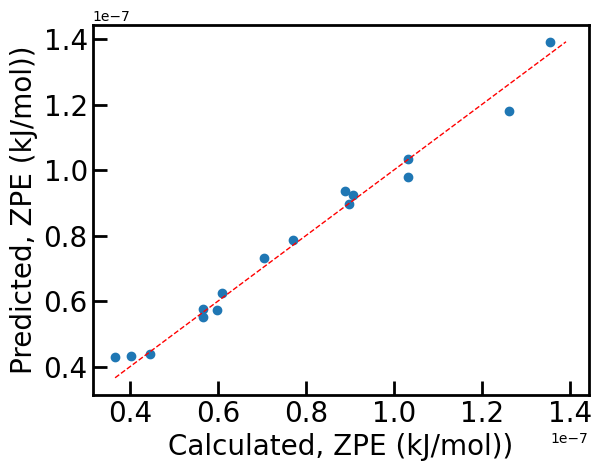

gpr5 0.9843910196081302
RMSE:  0.12479534089872467
RMSE unscaled:  3.581606098215295e-09
----------------------------------------


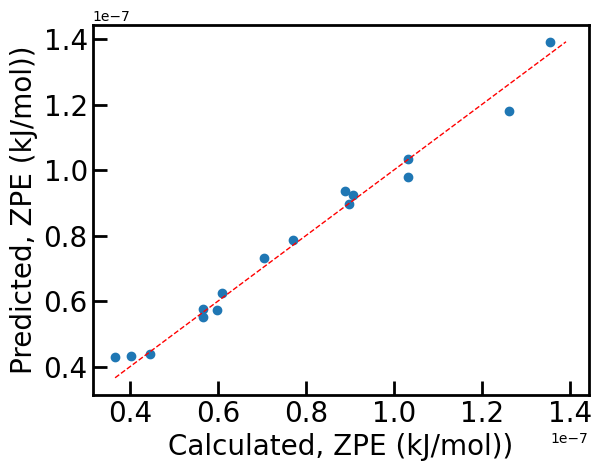

gpr6 0.9247314707675229
RMSE:  0.2740424358591663
RMSE unscaled:  7.864973582944028e-09
----------------------------------------


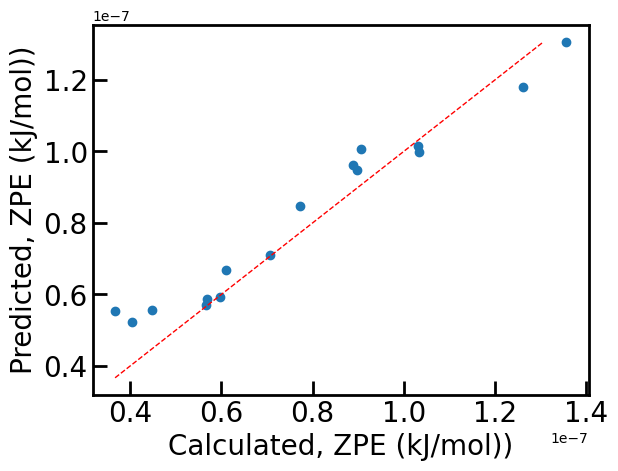

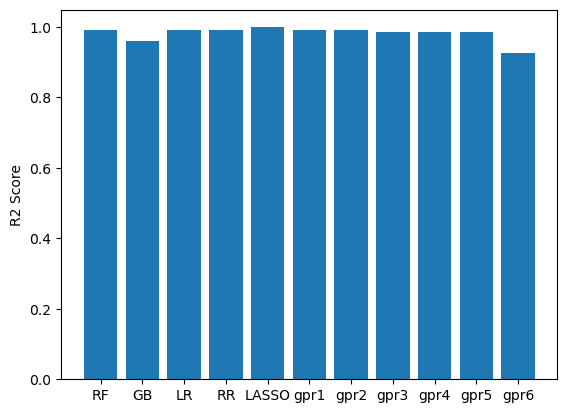

In [23]:
run_models()

In [24]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['Coef_b', 'mean_A2B', 'X_EA', 'X_Z', 'mean_X2X', 'X_Rvdw',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_MP', 'A_Kappa',
       'std_B2X'], dtype=object)

In [25]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9910063532058766
RMSE:  0.09472814175418201
RMSE unscaled:  2.71868234611993e-09
----------------------------------------


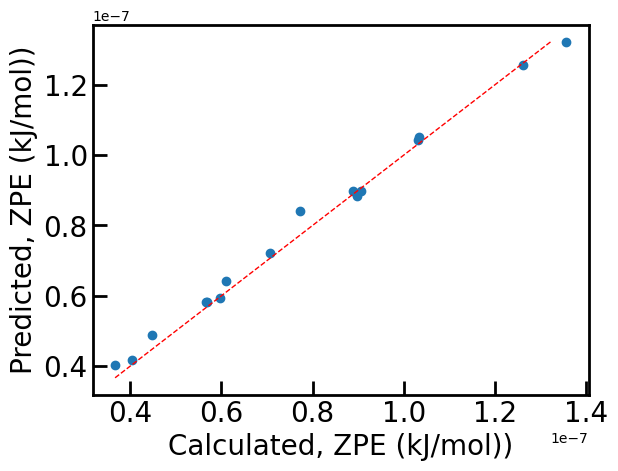

GB 0.9536868776911518
RMSE:  0.21496271304267517
RMSE unscaled:  6.1693950942235686e-09
----------------------------------------


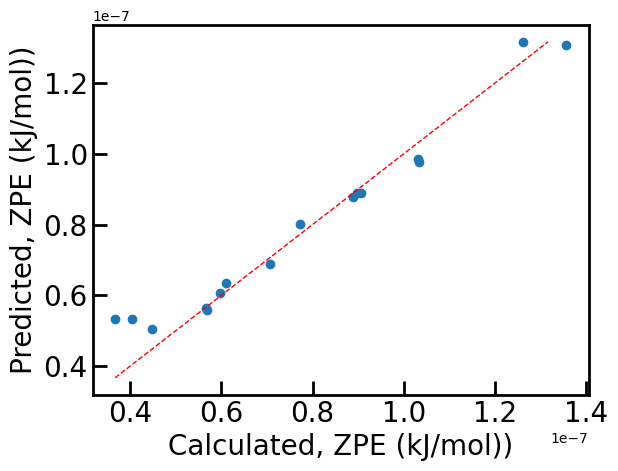

LR 0.9945600153200369
RMSE:  0.07367326932299026
RMSE unscaled:  2.1144109129588206e-09
----------------------------------------


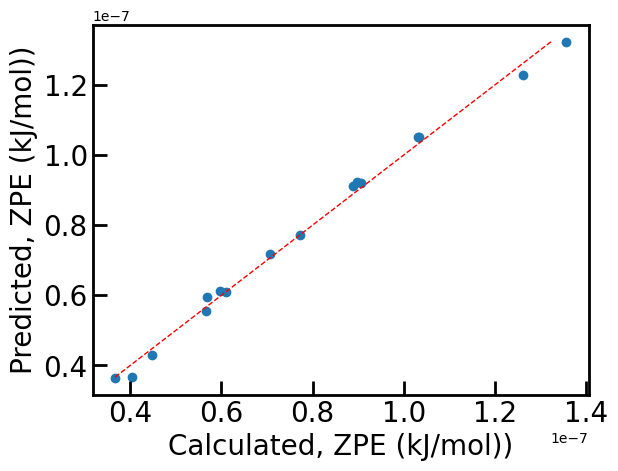

RR 0.994579562144943
RMSE:  0.07354078968160536
RMSE unscaled:  2.110608768679584e-09
----------------------------------------


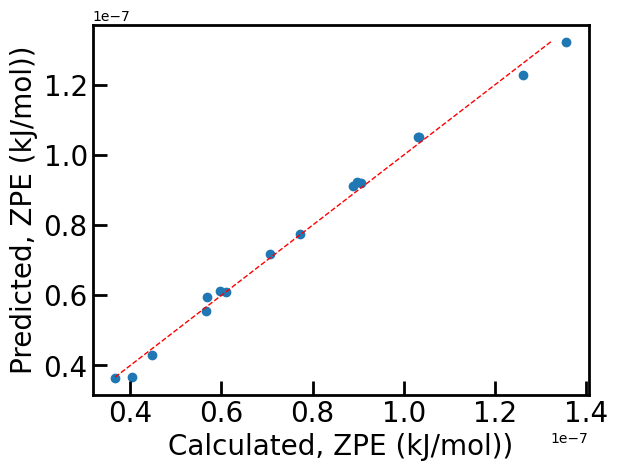

LASSO 0.9982194098280074
RMSE:  0.04214956434781956
RMSE unscaled:  1.2096856791134549e-09
----------------------------------------


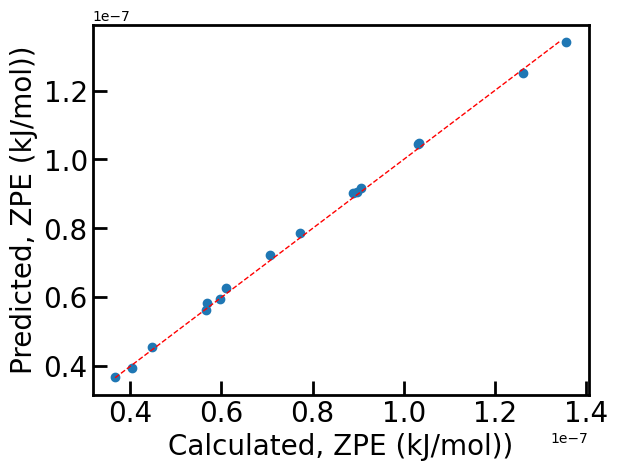

gpr1 0.9946025056977336
RMSE:  0.07338498342522712
RMSE unscaled:  2.1061371543231034e-09
----------------------------------------


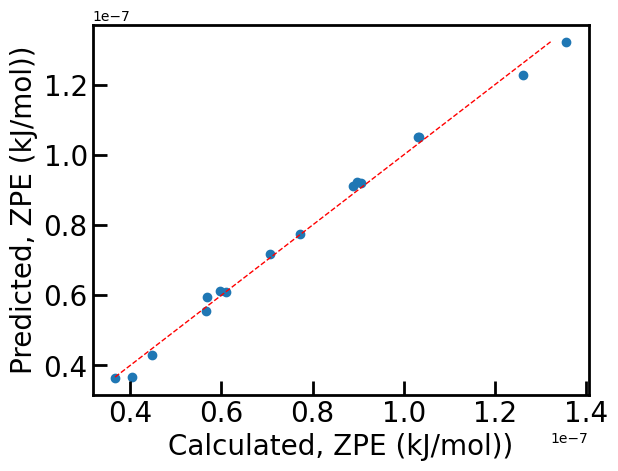

gpr2 0.9973377118448293
RMSE:  0.05153931405643733
RMSE unscaled:  1.4791699769639064e-09
----------------------------------------


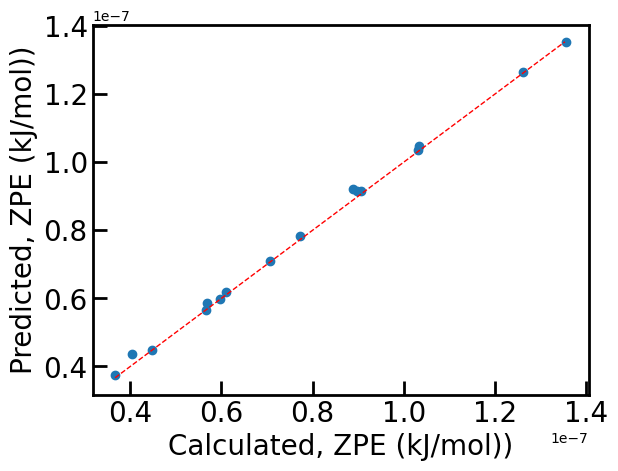

gpr3 0.9927655345138702
RMSE:  0.08495996576480624
RMSE unscaled:  2.4383372752219665e-09
----------------------------------------


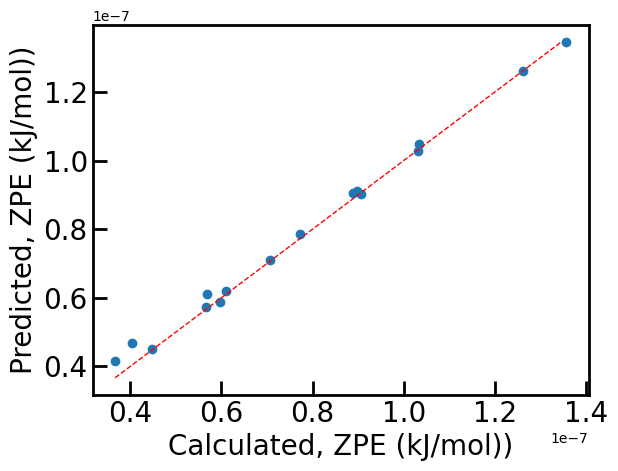

gpr4 0.9927655347055877
RMSE:  0.08495996463906202
RMSE unscaled:  2.4383372429132898e-09
----------------------------------------


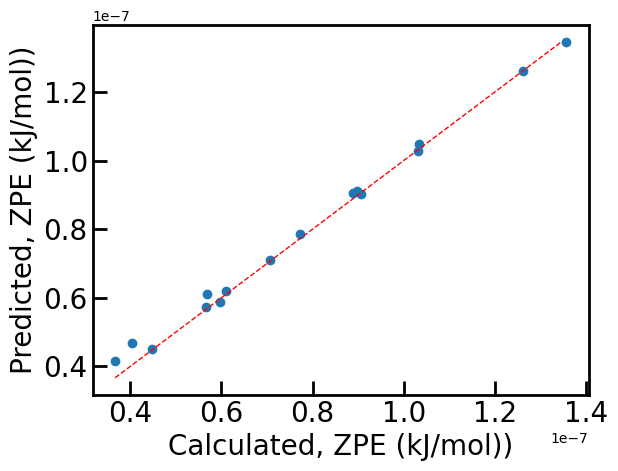

gpr5 0.9927654812138038
RMSE:  0.08496027873633696
RMSE unscaled:  2.4383462574542746e-09
----------------------------------------


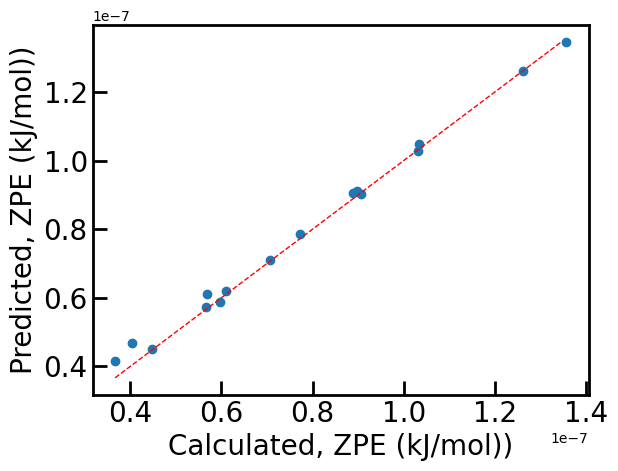

gpr6 0.9382663322571958
RMSE:  0.24818306534718948
RMSE unscaled:  7.122813831989322e-09
----------------------------------------


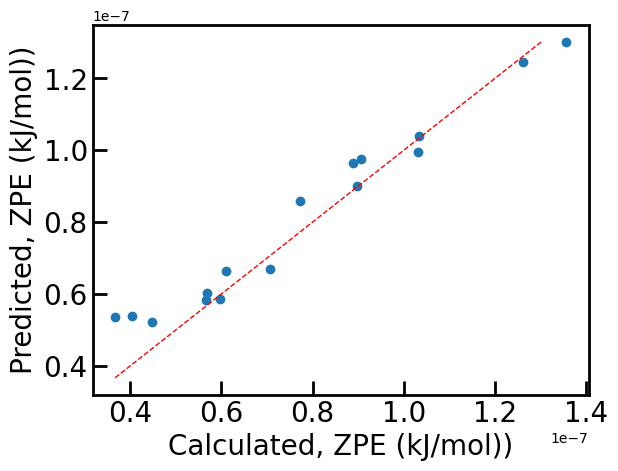

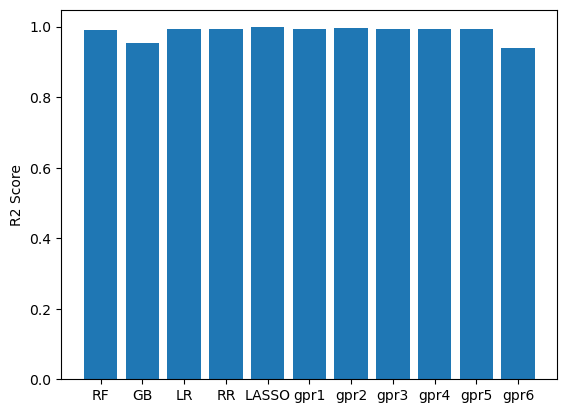

In [26]:
run_models()

In [27]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['Coef_b', 'mean_A2B', 'X_EA', 'X_Z', 'mean_X2X', 'X_Rvdw',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh'], dtype=object)

In [28]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9918333395141494
RMSE:  0.09026790323509813
RMSE unscaled:  2.5906742220633614e-09
----------------------------------------


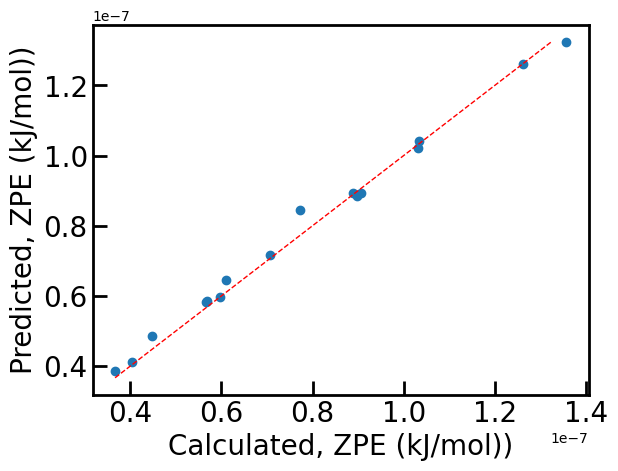

GB 0.9621244759199048
RMSE:  0.19439738994508454
RMSE unscaled:  5.579173647752474e-09
----------------------------------------


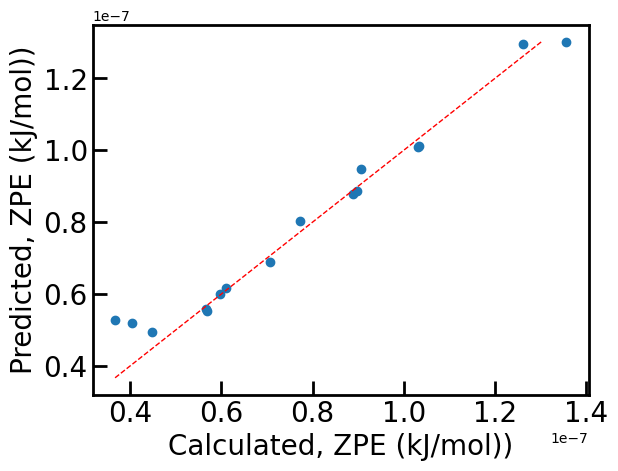

LR 0.9947560610105235
RMSE:  0.07233357320423411
RMSE unscaled:  2.0759618510456333e-09
----------------------------------------


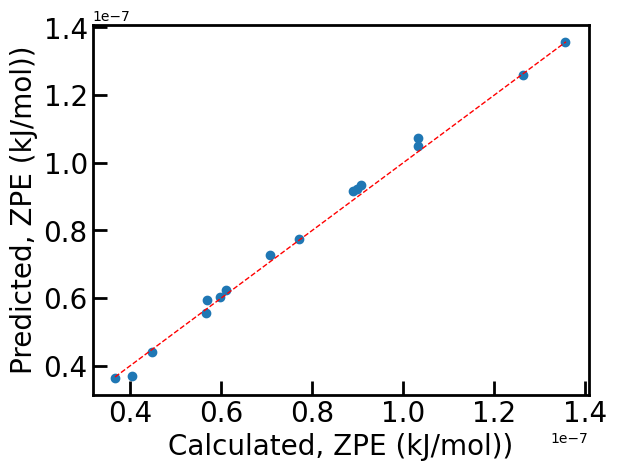

RR 0.9947901192603978
RMSE:  0.07209829510295317
RMSE unscaled:  2.069209407594973e-09
----------------------------------------


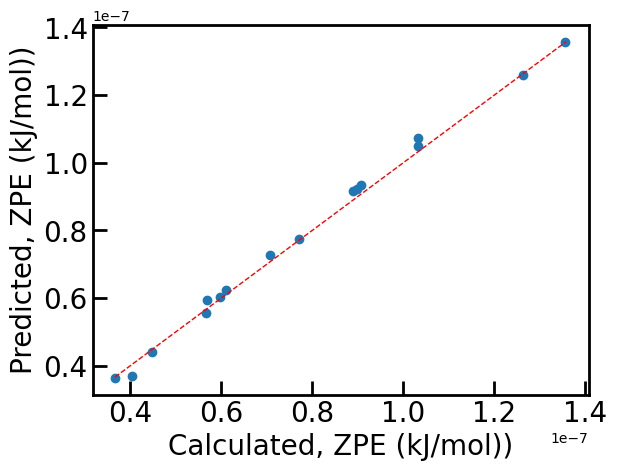

LASSO 0.9978914955009306
RMSE:  0.04586679245481482
RMSE unscaled:  1.3163695245246037e-09
----------------------------------------


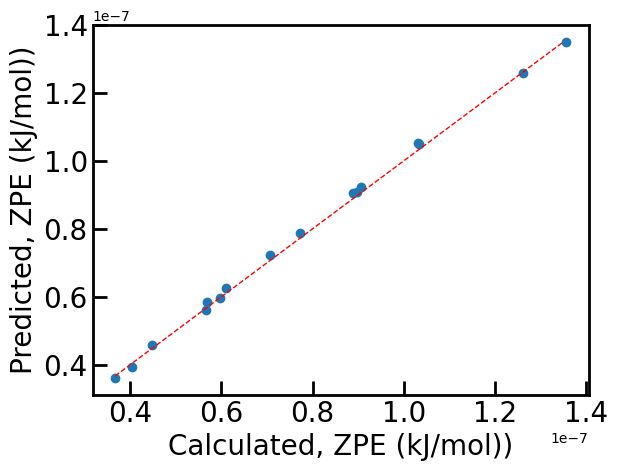

gpr1 0.9952517460295283
RMSE:  0.06883004828803845
RMSE unscaled:  1.9754112526440575e-09
----------------------------------------


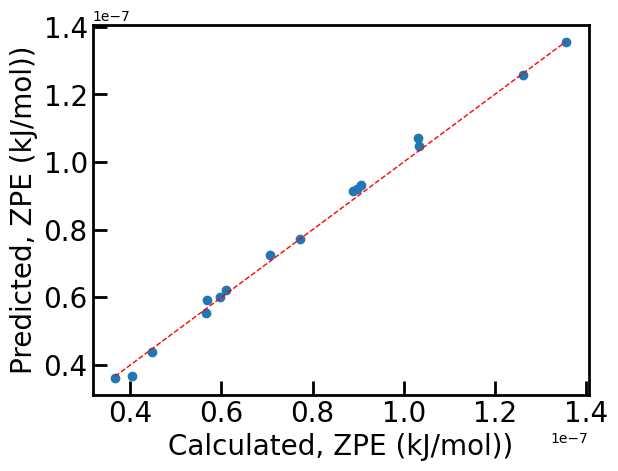

gpr2 0.9961058144212528
RMSE:  0.06233320049112404
RMSE unscaled:  1.7889527717341881e-09
----------------------------------------


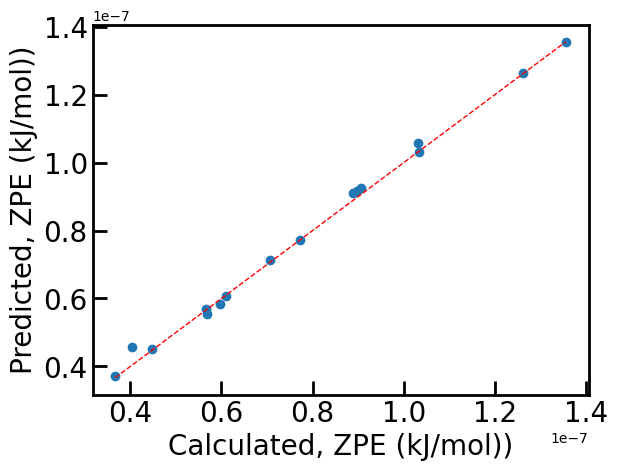

gpr3 0.9845925403850027
RMSE:  0.12398713456002394
RMSE unscaled:  3.5584107070215166e-09
----------------------------------------


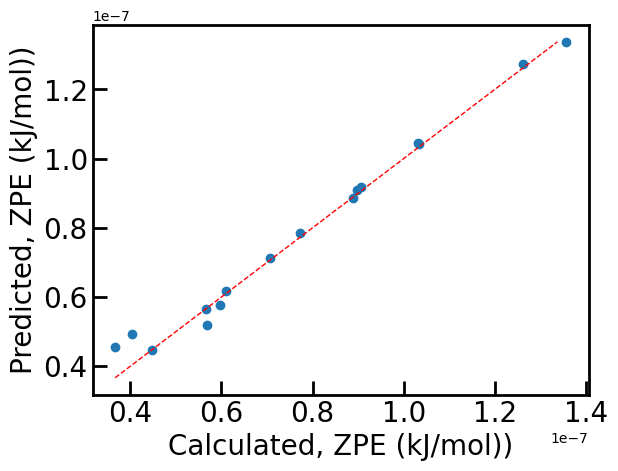

gpr4 0.9845925268973088
RMSE:  0.12398718882919595
RMSE unscaled:  3.558412264537975e-09
----------------------------------------


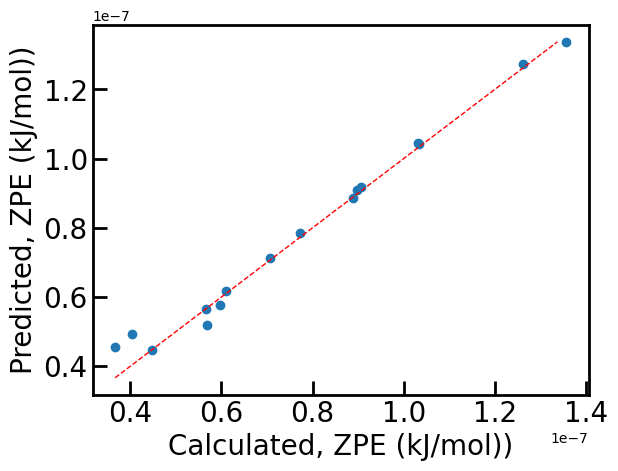

gpr5 0.9917071514568566
RMSE:  0.09096262213373373
RMSE unscaled:  2.610612542083801e-09
----------------------------------------


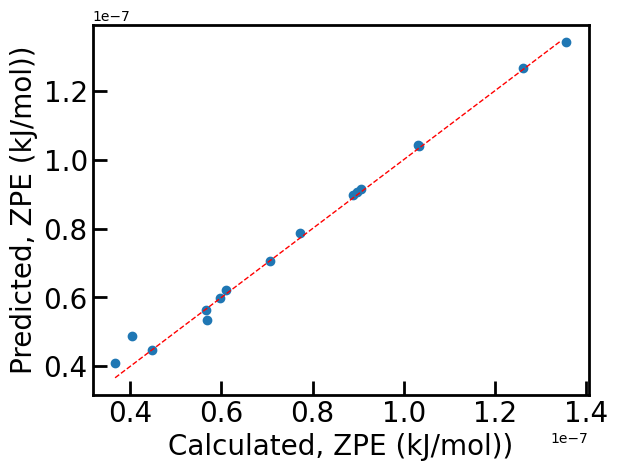

gpr6 0.9780052299020671
RMSE:  0.14813948060205795
RMSE unscaled:  4.251579131799137e-09
----------------------------------------


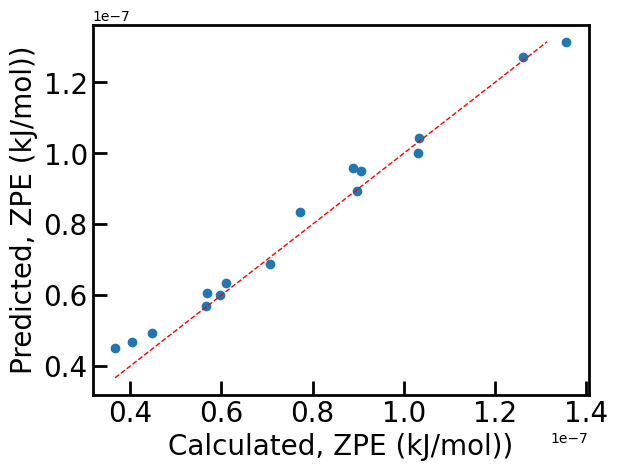

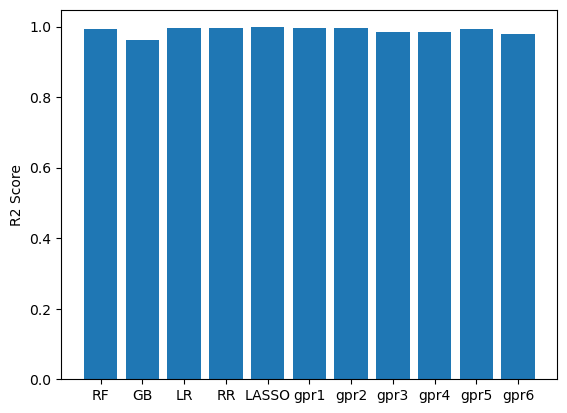

In [29]:
run_models()

# Min-Max scaling

In [30]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data['Coef_a']).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data['Coef_a']).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std['Coef_a'] 
X = data_std.drop(['Coef_a'], axis=1)

In [31]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [32]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'A_Rc', 'B_Hv', 'X_Hv', 'A_MendeleevNo', 'A_MV', 'A_Ra', 'X_Hf', 'X_Rc', 'A_M', 'X_CvM', 'B_M', 'X_Ra', 'X_M', 'X_BP', 'A_Hf', 'A_BP', 'B_BP', 'X_ChiA', 'X_MP', 'X_IEII', 'A_Hv', 'X_MendeleevNo', 'X_B'}


In [33]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape
#data_std.to_csv('scaled_non_corr_all.csv',index=False)

(80, 52)

In [34]:
print(correlated_features)

{'A_Rc', 'B_Hv', 'X_Hv', 'A_MendeleevNo', 'A_MV', 'A_Ra', 'X_Hf', 'X_Rc', 'A_M', 'X_CvM', 'B_M', 'X_Ra', 'X_M', 'X_BP', 'A_Hf', 'A_BP', 'B_BP', 'X_ChiA', 'X_MP', 'X_IEII', 'A_Hv', 'X_MendeleevNo', 'X_B'}


### Test-train splitting 

In [35]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('Coef_a')
X = df_train

Y_test = df_test.pop('Coef_a')
X_test = df_test

RF 0.9888684061016992
RMSE:  0.02489753842304643
RMSE unscaled:  3.024608931928527e-09
----------------------------------------


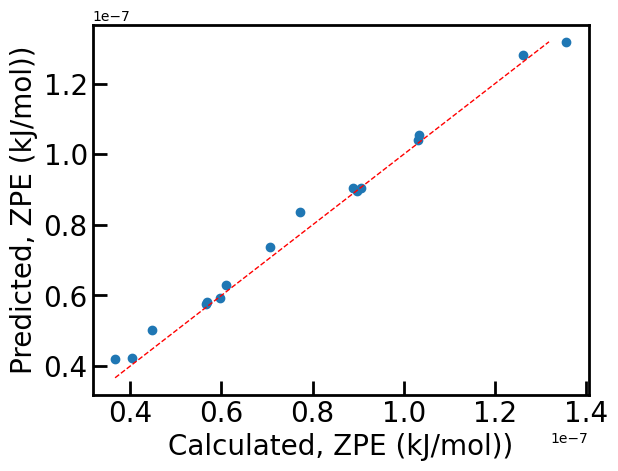

GB 0.9578107956242413
RMSE:  0.04847060068842467
RMSE unscaled:  5.8883175230867604e-09
----------------------------------------


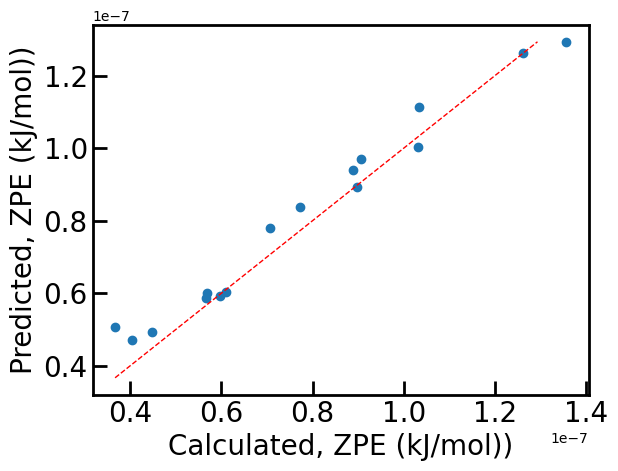

LR 0.9692843155013056
RMSE:  0.04135783852430533
RMSE unscaled:  5.024243187434175e-09
----------------------------------------


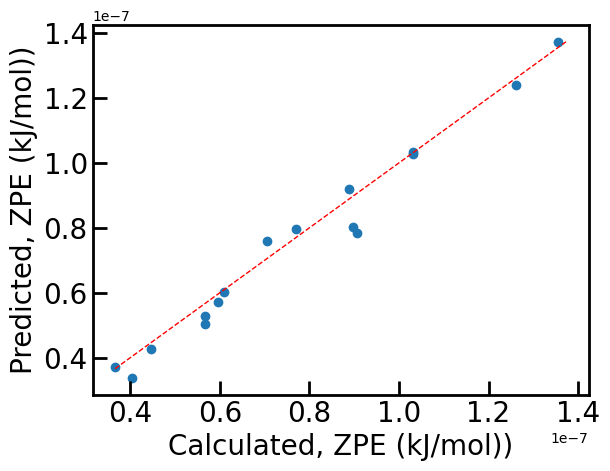

RR 0.9894255608787538
RMSE:  0.02426645882345016
RMSE unscaled:  2.947943963638734e-09
----------------------------------------


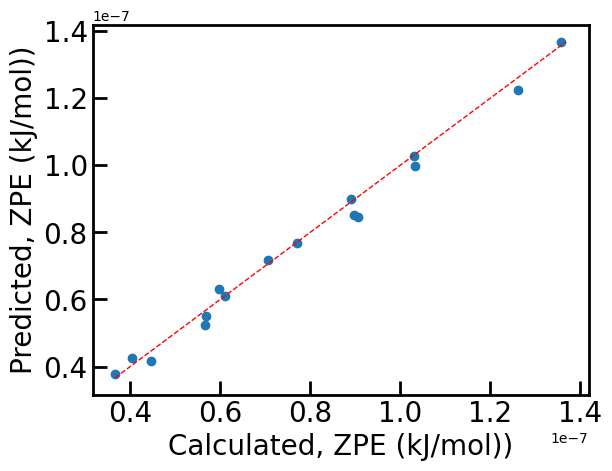

LASSO 0.9749051211492495
RMSE:  0.037382667328800544
RMSE unscaled:  4.541330455276711e-09
----------------------------------------


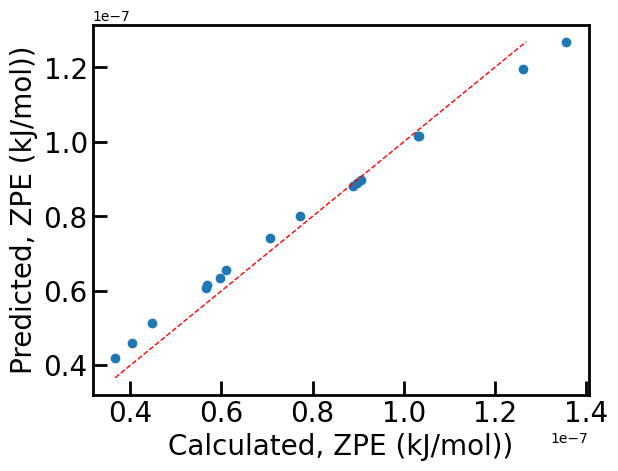

gpr1 0.959747382217599
RMSE:  0.04734507392135375
RMSE unscaled:  5.7515860014815495e-09
----------------------------------------


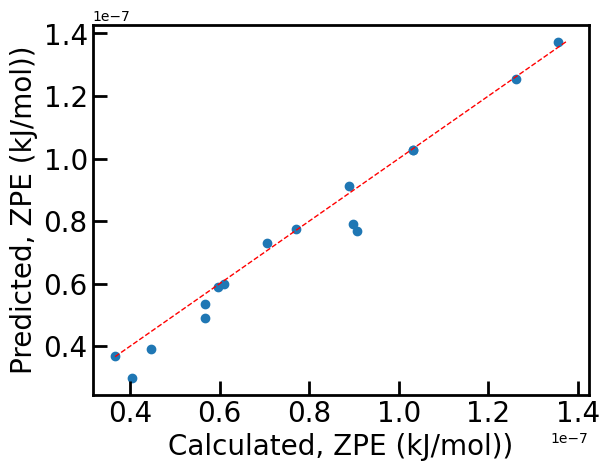

gpr2 0.9900042301683173
RMSE:  0.023593146143172337
RMSE unscaled:  2.8661484257768876e-09
----------------------------------------


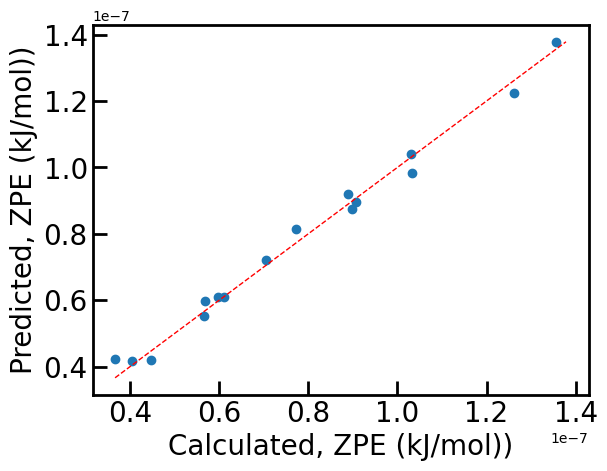

gpr3 0.9900042196941778
RMSE:  0.023593158504293135
RMSE unscaled:  2.866149927433627e-09
----------------------------------------


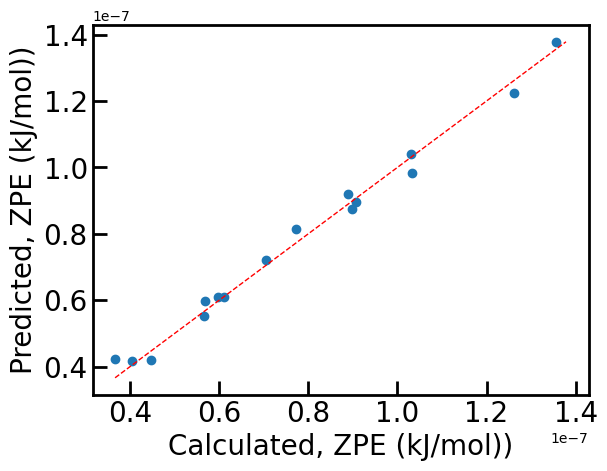

gpr4 0.9900042194455947
RMSE:  0.023593158797660028
RMSE unscaled:  2.8661499630724953e-09
----------------------------------------


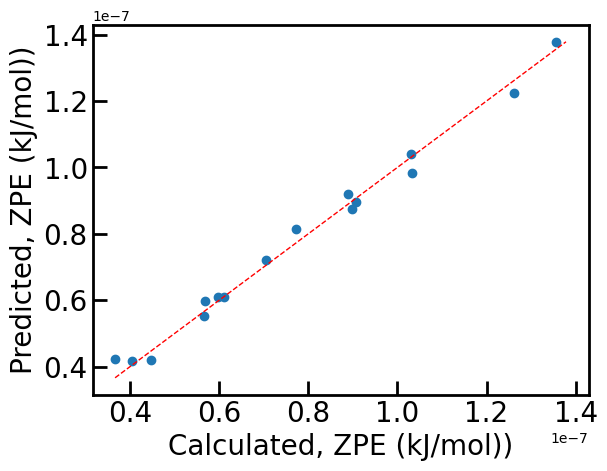

gpr5 0.9894308391604368
RMSE:  0.024260401708210925
RMSE unscaled:  2.947208131664381e-09
----------------------------------------


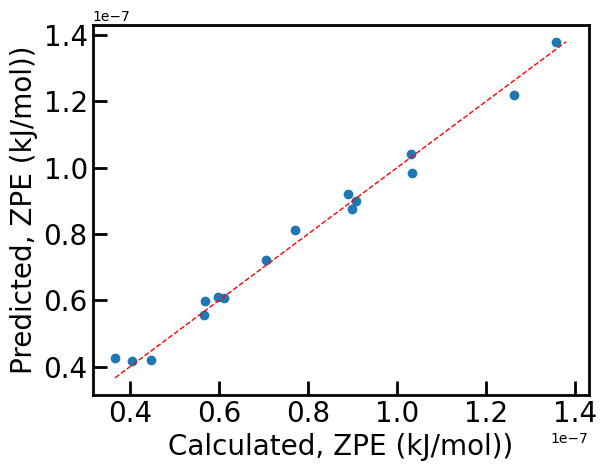

gpr6 0.9153094513482091
RMSE:  0.06867445276607033
RMSE unscaled:  8.34272688738136e-09
----------------------------------------


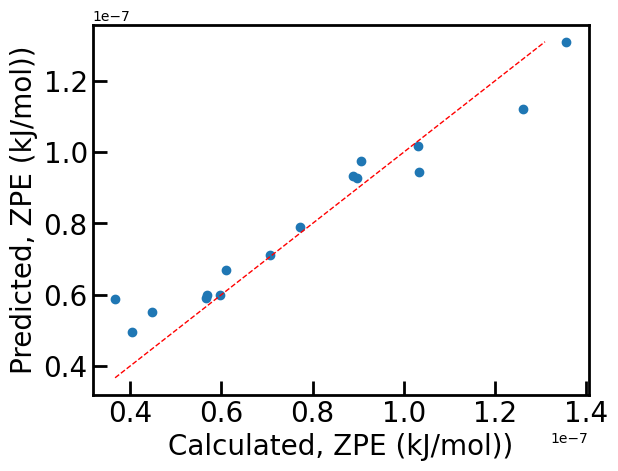

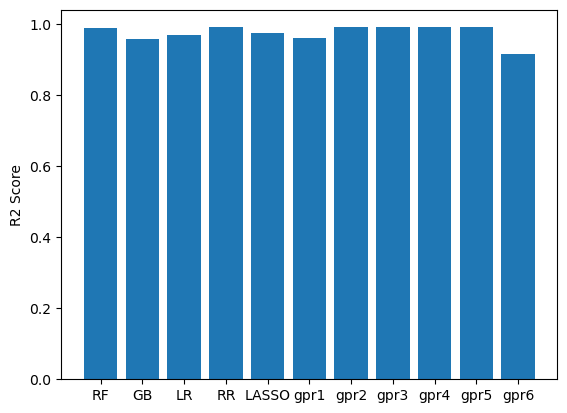

In [36]:
run_models()

## Feature selection


In [37]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature        Score
0     Coef_b  3230.667638
2   mean_A2B   109.296724
26      X_EA    73.368669
15       X_Z    66.718735
5   mean_X2X    56.945060
33    X_Rvdw    56.130242
31    A_Rvdw    51.699207
3   mean_A2X    40.526215
19     A_IEI    32.506577
10     E_coh    30.740923
30    A_ChiA    16.249435
7    std_A2X    15.249756
27    A_ChiP    14.642045
24      A_EA    13.518905
42      B_Hf    13.440569
45   X_Kappa    12.439648
37      B_MP    11.182324
36      A_MP    10.204076
43   A_Kappa     8.683247
8    std_B2X     8.580932
13       A_Z     8.474870
44   B_Kappa     8.031022
14       B_Z     6.255140
18       X_G     6.249672
46     A_CvM     5.656104
16       A_G     5.063472
12        OF     4.732281
35      B_Ra     4.706026
21     X_IEI     4.443059
48       A_B     4.300002


In [38]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['Coef_b', 'mean_A2B', 'X_EA', 'X_Z', 'mean_X2X', 'X_Rvdw',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_MP', 'A_Kappa',
       'std_B2X', 'A_Z', 'B_Kappa', 'B_Z', 'X_G', 'A_CvM', 'A_G', 'OF',
       'B_Ra', 'X_IEI', 'A_B', 'std_A2B', 'B_EA', 'B_Rho', 'X_MV',
       'density', 'B_IEI', 'B_ChiP', 'B_CvM', 'std_X2X', 'A_Rho'],
      dtype=object)

In [39]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.988692777861332
RMSE:  0.02509317967949059
RMSE unscaled:  3.048375871520713e-09
----------------------------------------


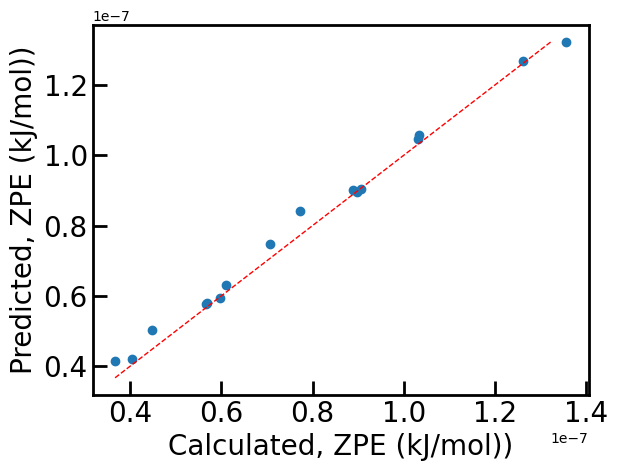

GB 0.9544780946282183
RMSE:  0.0503486638856004
RMSE unscaled:  6.116468861760701e-09
----------------------------------------


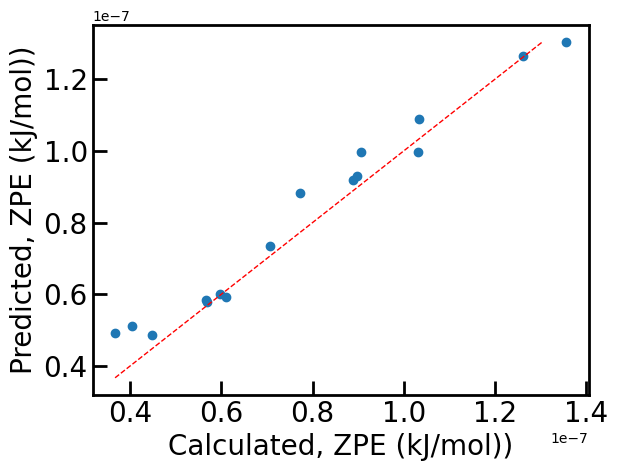

LR 0.987336158497157
RMSE:  0.02655586593148014
RMSE unscaled:  3.2260662852156473e-09
----------------------------------------


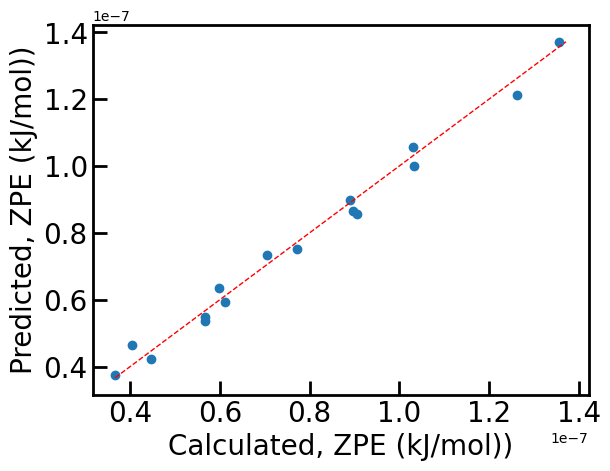

RR 0.9887513054697512
RMSE:  0.02502815269133446
RMSE unscaled:  3.0404762468328618e-09
----------------------------------------


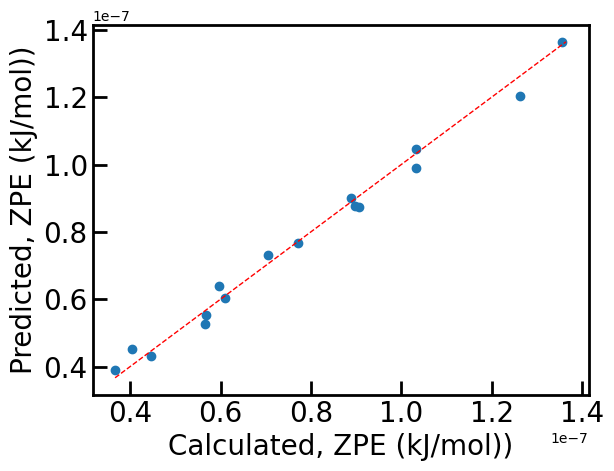

LASSO 0.9749051211492495
RMSE:  0.037382667328800544
RMSE unscaled:  4.541330455276711e-09
----------------------------------------


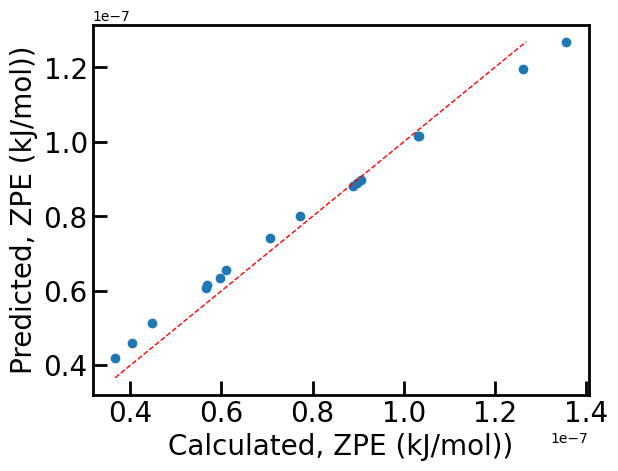

gpr1 0.9878935930666789
RMSE:  0.02596482310380105
RMSE unscaled:  3.154265073972385e-09
----------------------------------------


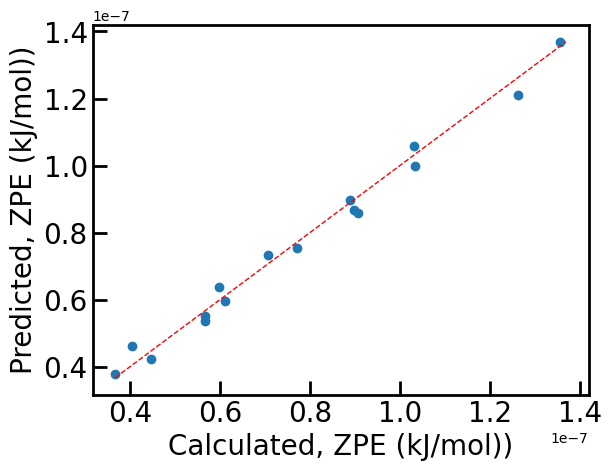

gpr2 0.9922782353025709
RMSE:  0.02073652673260011
RMSE unscaled:  2.519119878716211e-09
----------------------------------------


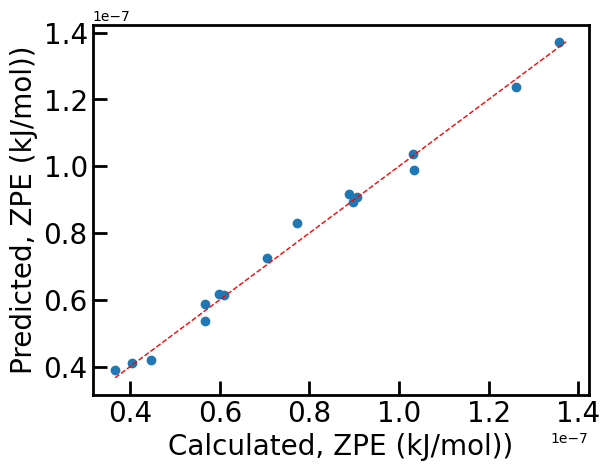

gpr3 0.9922782848592058
RMSE:  0.020736460191195818
RMSE unscaled:  2.519111795116847e-09
----------------------------------------


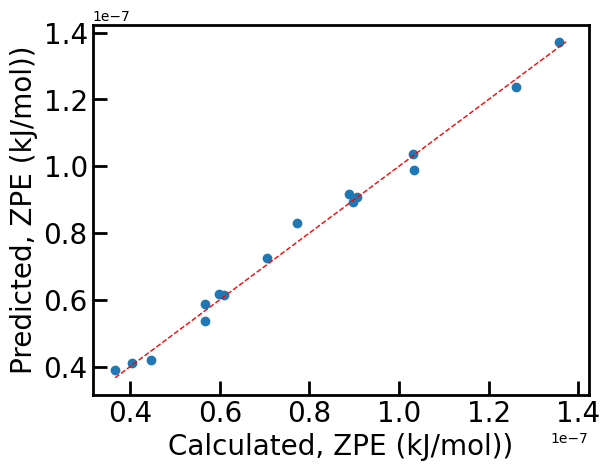

gpr4 0.9922782791987992
RMSE:  0.020736467791630006
RMSE unscaled:  2.519112718434674e-09
----------------------------------------


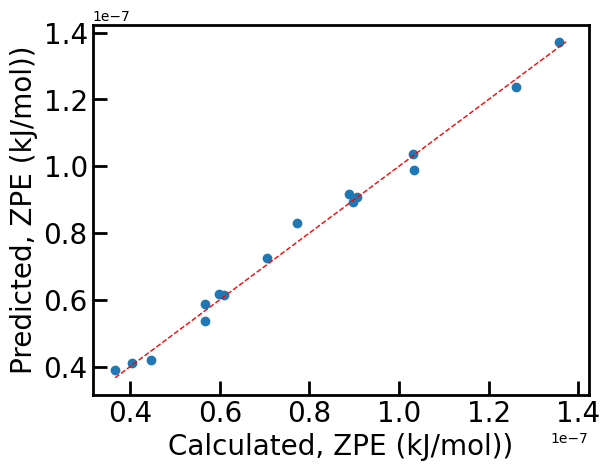

gpr5 0.9922782488176805
RMSE:  0.02073650858541719
RMSE unscaled:  2.5191176741556376e-09
----------------------------------------


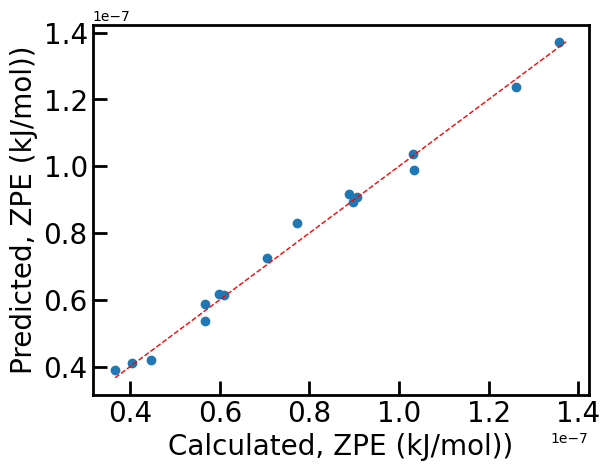

gpr6 0.9311154656949808
RMSE:  0.06193535020333849
RMSE unscaled:  7.524045560011523e-09
----------------------------------------


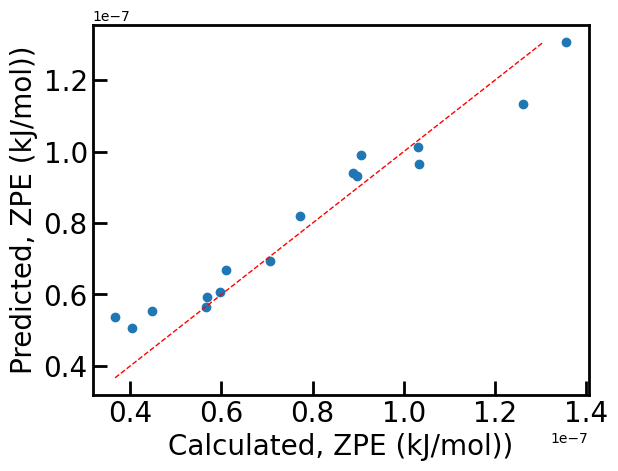

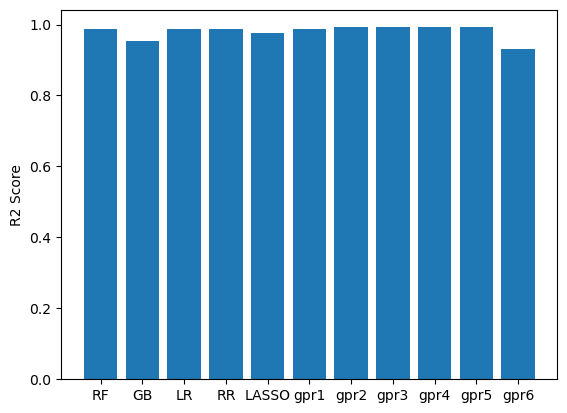

In [40]:
run_models()

In [41]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['Coef_b', 'mean_A2B', 'X_EA', 'X_Z', 'mean_X2X', 'X_Rvdw',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_MP', 'A_Kappa',
       'std_B2X', 'A_Z', 'B_Kappa', 'B_Z', 'X_G', 'A_CvM', 'A_G', 'OF',
       'B_Ra', 'X_IEI', 'A_B'], dtype=object)

In [42]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9889409625805314
RMSE:  0.02481626385200144
RMSE unscaled:  3.0147355143502697e-09
----------------------------------------


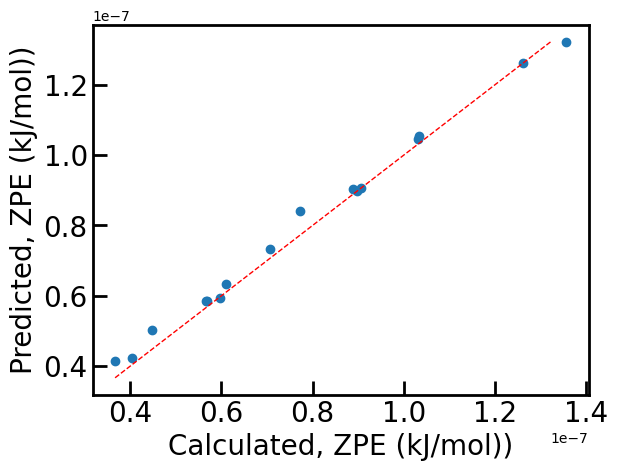

GB 0.967102007559934
RMSE:  0.04280183933506292
RMSE unscaled:  5.1996636517274084e-09
----------------------------------------


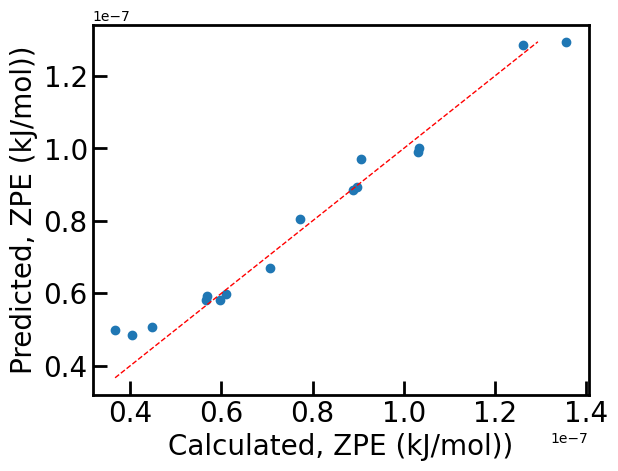

LR 0.9908495620351889
RMSE:  0.02257348822834788
RMSE unscaled:  2.7422780903129246e-09
----------------------------------------


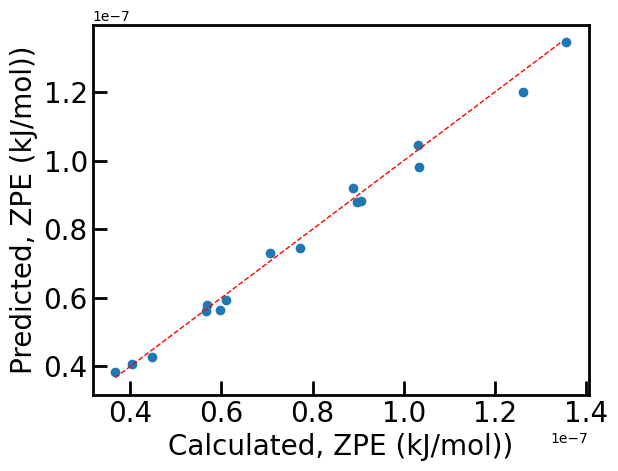

RR 0.9911668990049602
RMSE:  0.02217861041551587
RMSE unscaled:  2.69430744600993e-09
----------------------------------------


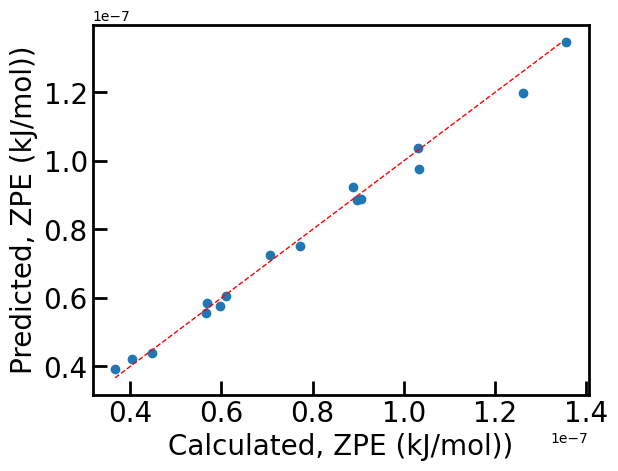

LASSO 0.9749051211492495
RMSE:  0.037382667328800544
RMSE unscaled:  4.541330455276711e-09
----------------------------------------


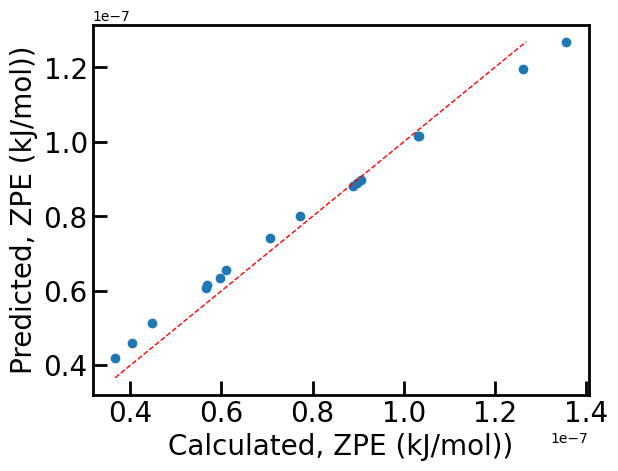

gpr1 0.9910161128612425
RMSE:  0.022367110224223215
RMSE unscaled:  2.717206826478618e-09
----------------------------------------


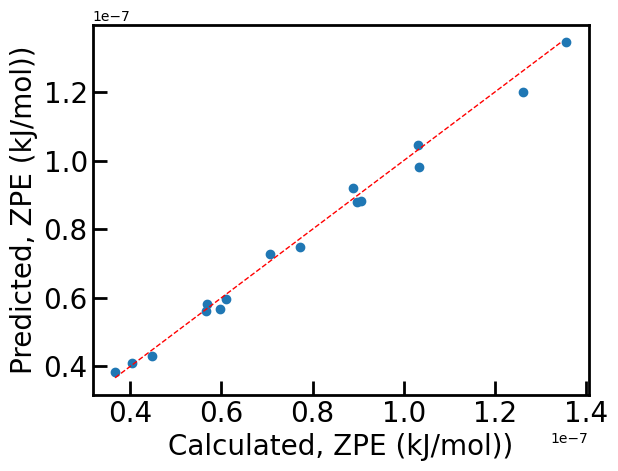

gpr2 0.992353634257215
RMSE:  0.02063503776168762
RMSE unscaled:  2.5067907704044426e-09
----------------------------------------


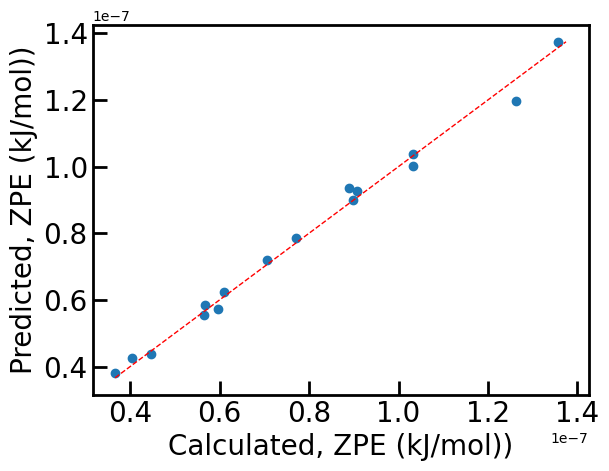

gpr3 0.9884786669706369
RMSE:  0.025329644782361778
RMSE unscaled:  3.0771021837400577e-09
----------------------------------------


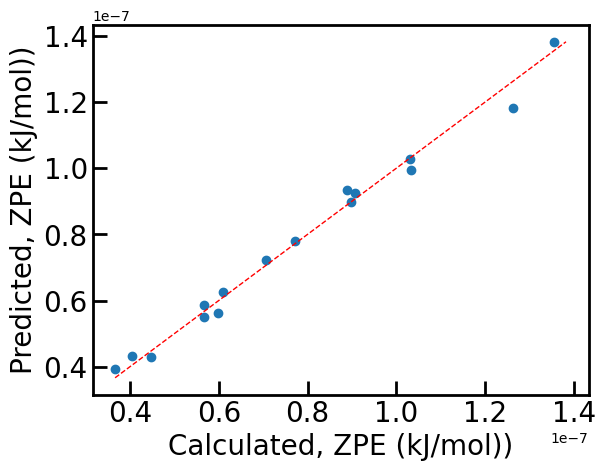

gpr4 0.9884786651338358
RMSE:  0.025329646801464864
RMSE unscaled:  3.0771024290252416e-09
----------------------------------------


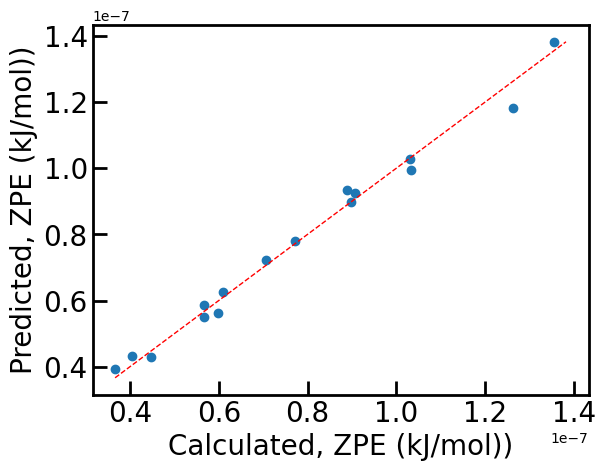

gpr5 0.9875359896878515
RMSE:  0.026345511451972215
RMSE unscaled:  3.2005119502135234e-09
----------------------------------------


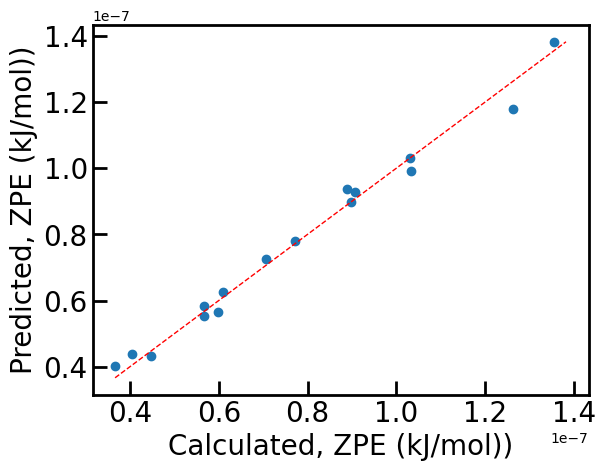

gpr6 0.9382128986499396
RMSE:  0.05865791811367658
RMSE unscaled:  7.125895742798888e-09
----------------------------------------


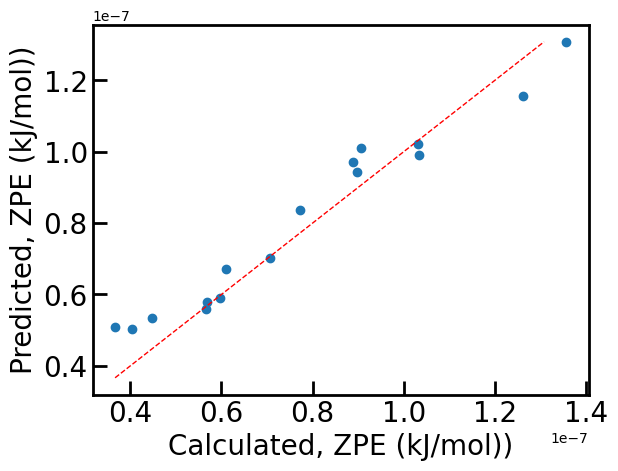

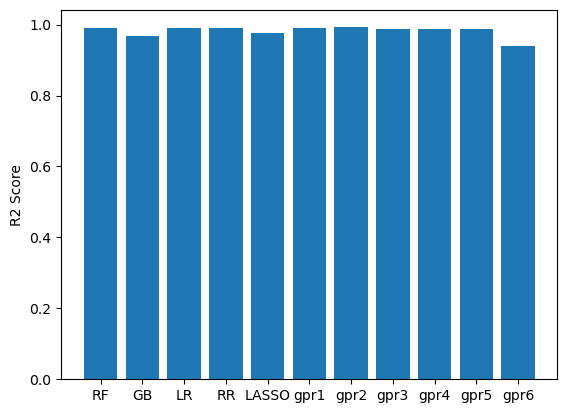

In [43]:
run_models()

In [44]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['Coef_b', 'mean_A2B', 'X_EA', 'X_Z', 'mean_X2X', 'X_Rvdw',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_MP', 'A_Kappa',
       'std_B2X'], dtype=object)

In [45]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9912541860040811
RMSE:  0.022068755977967463
RMSE unscaled:  2.6809620820074664e-09
----------------------------------------


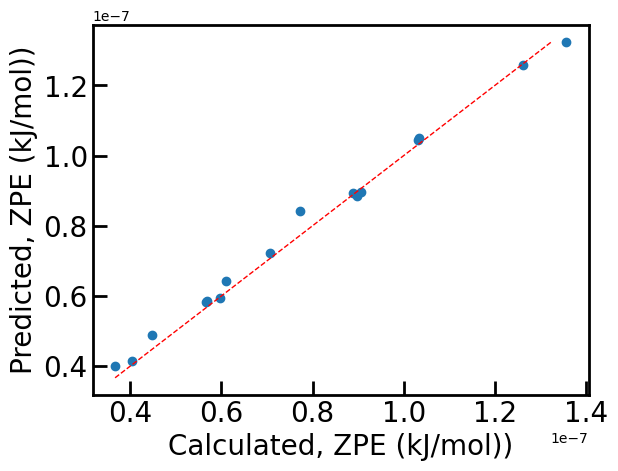

GB 0.9581140869906861
RMSE:  0.04829606278717081
RMSE unscaled:  5.867114266518882e-09
----------------------------------------


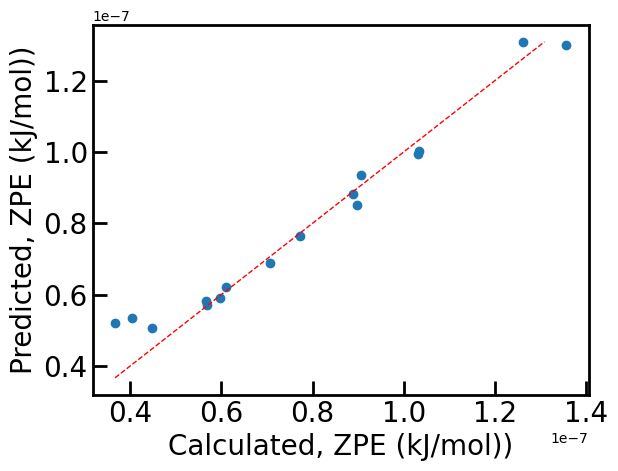

LR 0.9945600153200369
RMSE:  0.017405101992453185
RMSE unscaled:  2.1144109129588197e-09
----------------------------------------


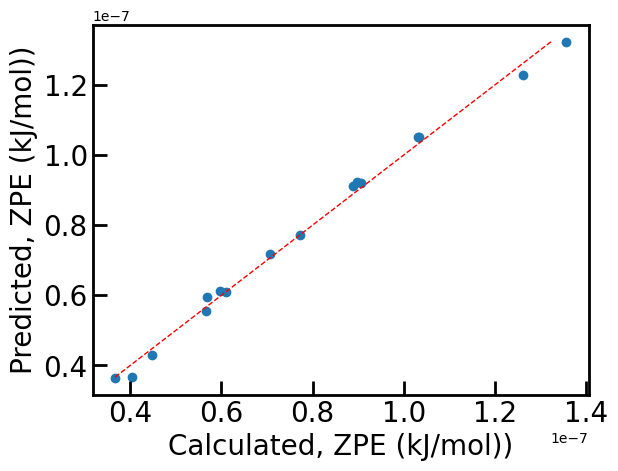

RR 0.9946945820424264
RMSE:  0.017188482477756593
RMSE unscaled:  2.0880954873995243e-09
----------------------------------------


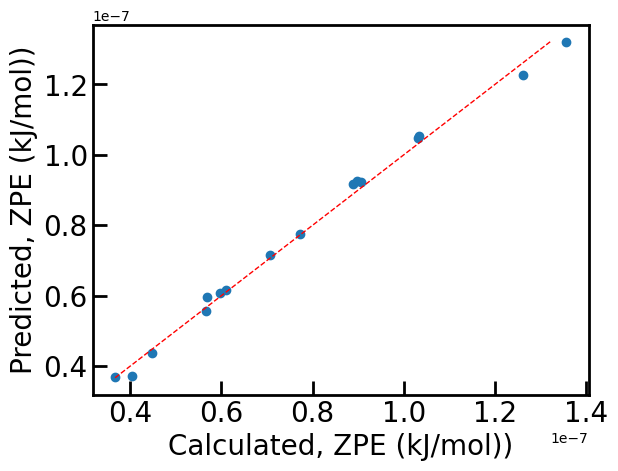

LASSO 0.9749051211492495
RMSE:  0.037382667328800544
RMSE unscaled:  4.541330455276711e-09
----------------------------------------


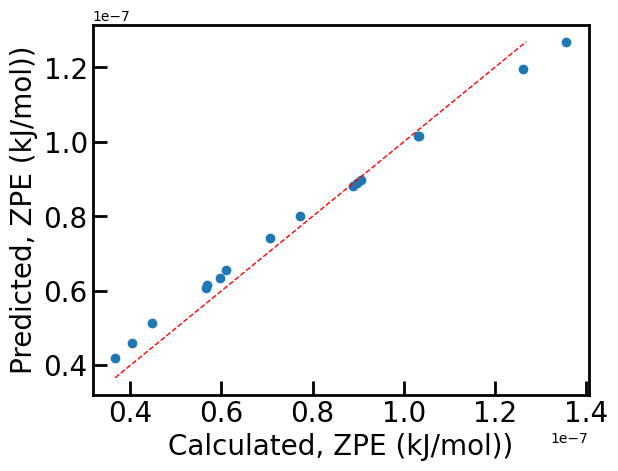

gpr1 0.9945716403067083
RMSE:  0.017386495112030245
RMSE unscaled:  2.112150507300785e-09
----------------------------------------


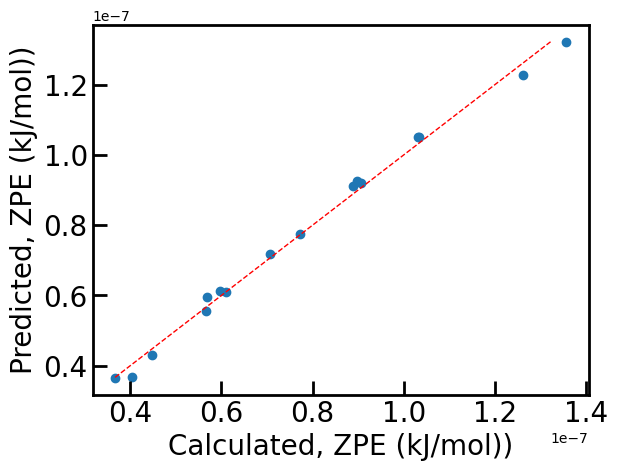

gpr2 0.9962436581083636
RMSE:  0.01446306343628242
RMSE unscaled:  1.7570054560870128e-09
----------------------------------------


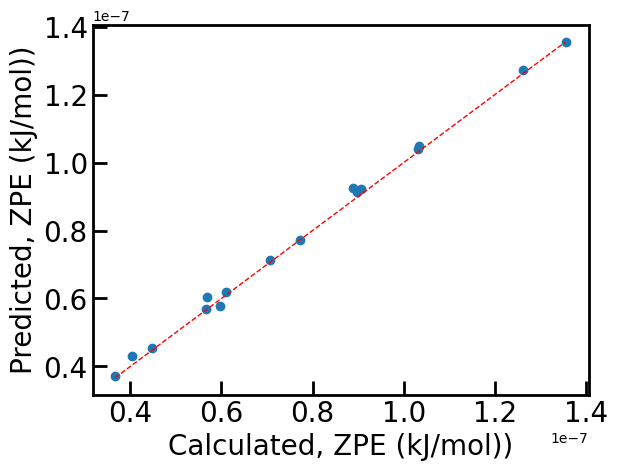

gpr3 0.9923273037133616
RMSE:  0.020670535986779898
RMSE unscaled:  2.511103174581005e-09
----------------------------------------


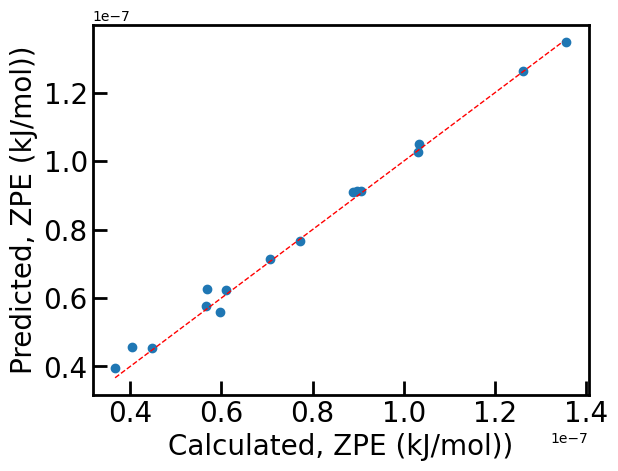

gpr4 0.9923273040565385
RMSE:  0.02067053552451423
RMSE unscaled:  2.5111031184239335e-09
----------------------------------------


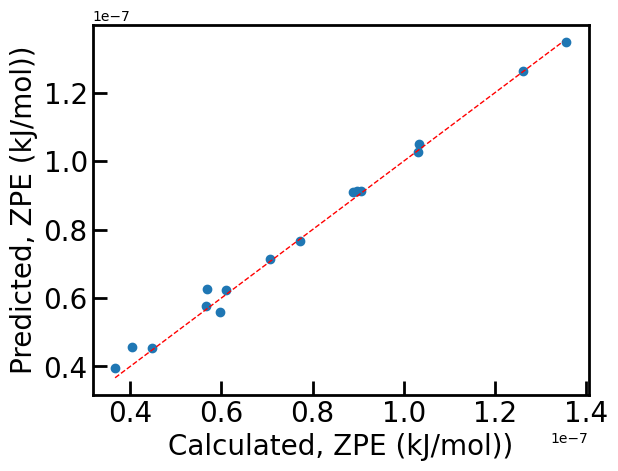

gpr5 0.9937020138948053
RMSE:  0.018727447286713352
RMSE unscaled:  2.27505239165258e-09
----------------------------------------


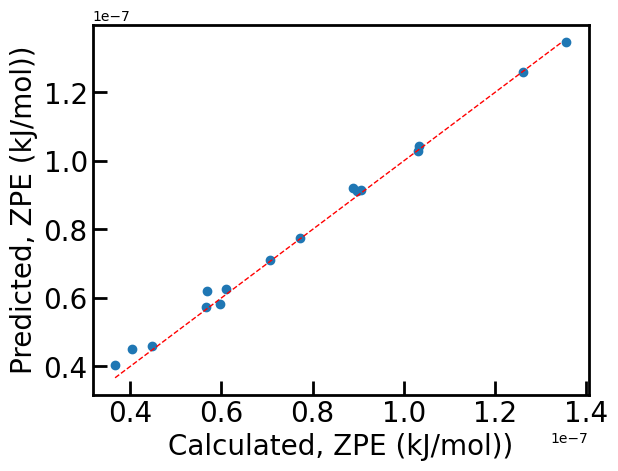

gpr6 0.9478821573561235
RMSE:  0.053872973803909166
RMSE unscaled:  6.544609952525476e-09
----------------------------------------


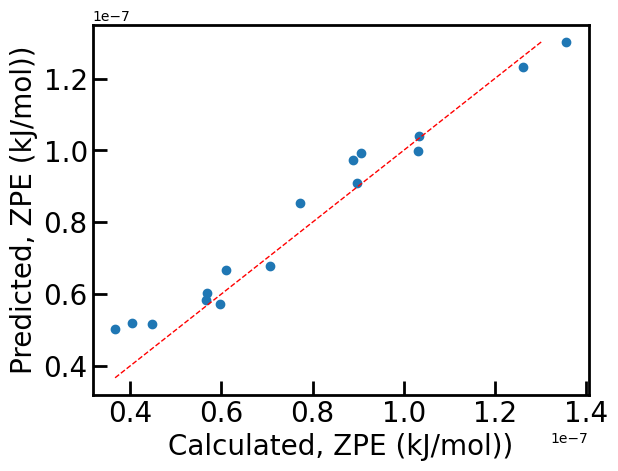

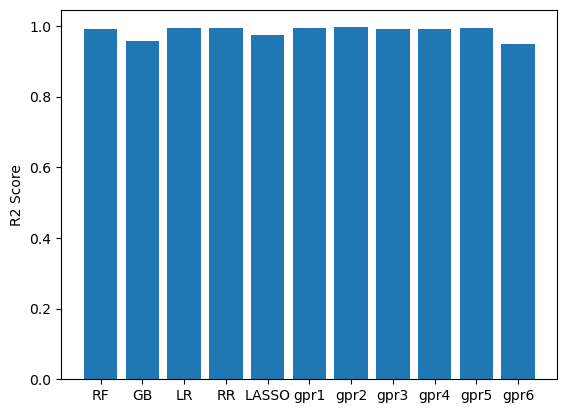

In [46]:
run_models()

In [47]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['Coef_b', 'mean_A2B', 'X_EA', 'X_Z', 'mean_X2X', 'X_Rvdw',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'E_coh'], dtype=object)

In [48]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9917981269050693
RMSE:  0.021371463183985234
RMSE unscaled:  2.5962533860306837e-09
----------------------------------------


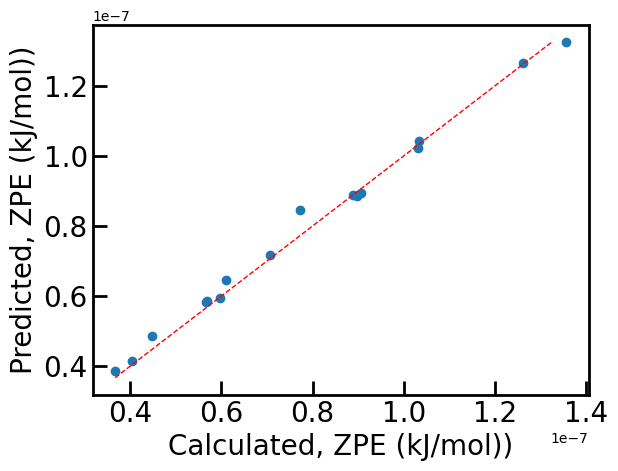

GB 0.9481635087344671
RMSE:  0.05372736391143437
RMSE unscaled:  6.526920935488003e-09
----------------------------------------


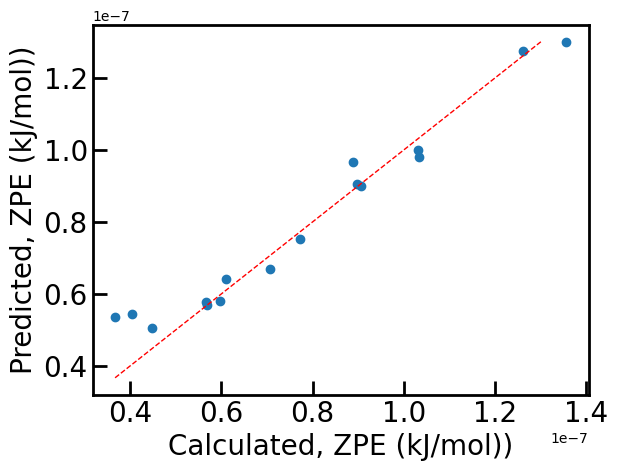

LR 0.9947560610105236
RMSE:  0.01708860256464003
RMSE unscaled:  2.075961851045623e-09
----------------------------------------


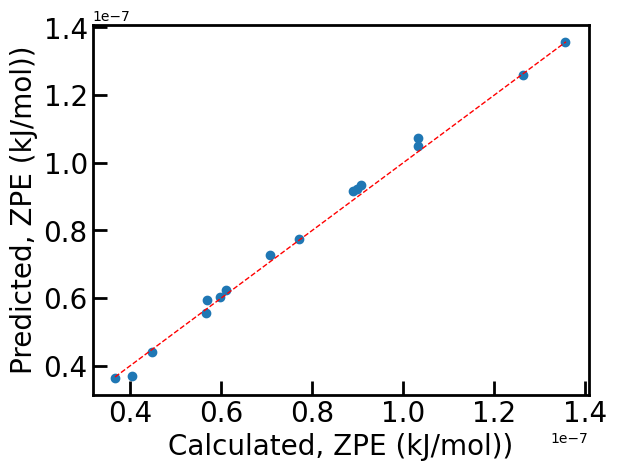

RR 0.9951863710167559
RMSE:  0.01637246387834512
RMSE unscaled:  1.9889637137091985e-09
----------------------------------------


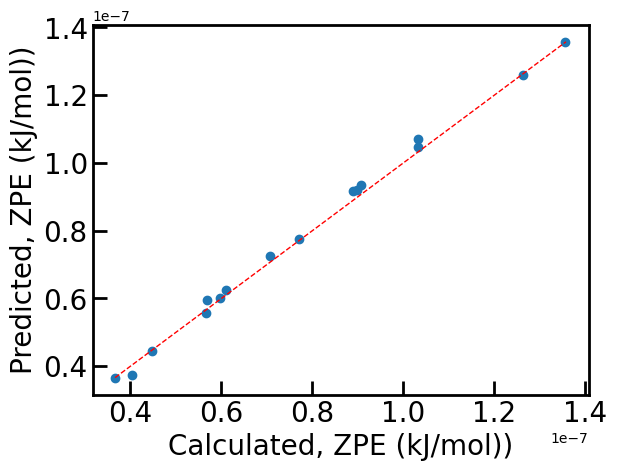

LASSO 0.9749051211492495
RMSE:  0.037382667328800544
RMSE unscaled:  4.541330455276711e-09
----------------------------------------


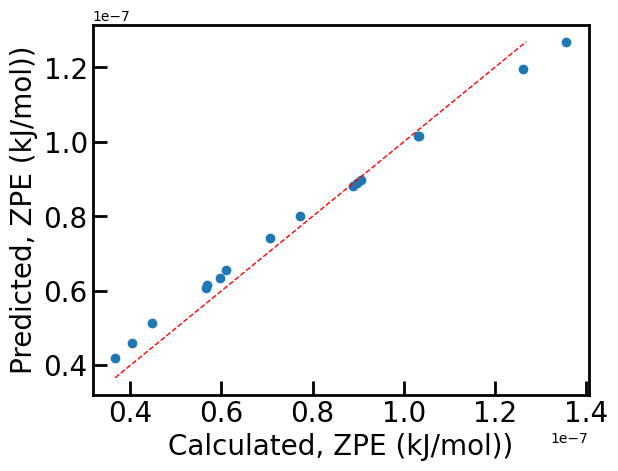

gpr1 0.9948438275316368
RMSE:  0.01694499527357969
RMSE unscaled:  2.0585161145293907e-09
----------------------------------------


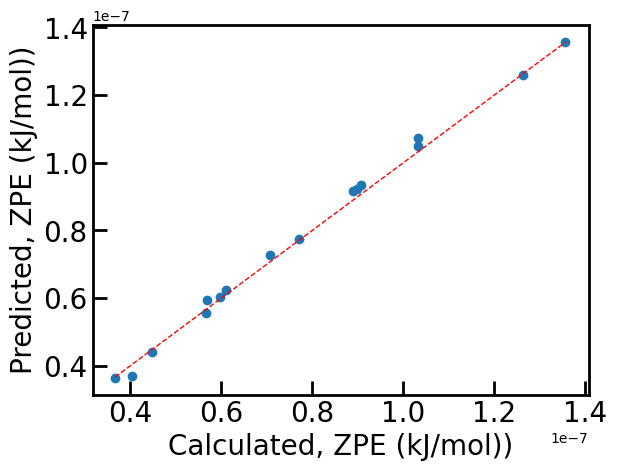

gpr2 0.995503250036105
RMSE:  0.01582439460445282
RMSE unscaled:  1.9223830263752277e-09
----------------------------------------


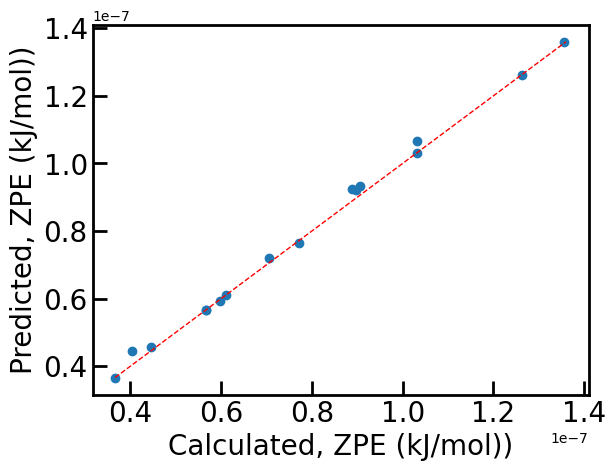

gpr3 0.9846329835911573
RMSE:  0.029253141490409848
RMSE unscaled:  3.5537373830081776e-09
----------------------------------------


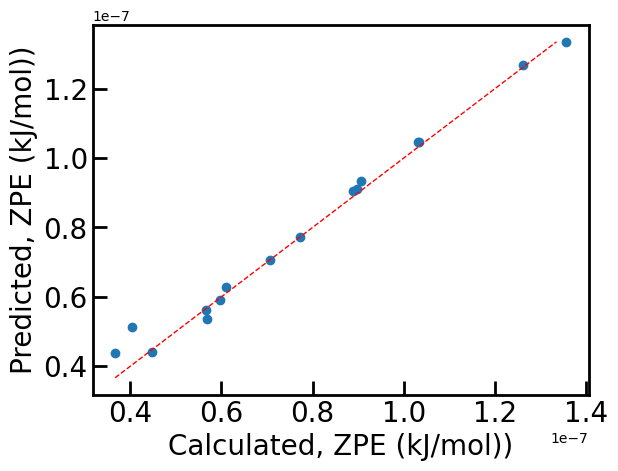

gpr4 0.9846329963668804
RMSE:  0.02925312933027075
RMSE unscaled:  3.553735905767146e-09
----------------------------------------


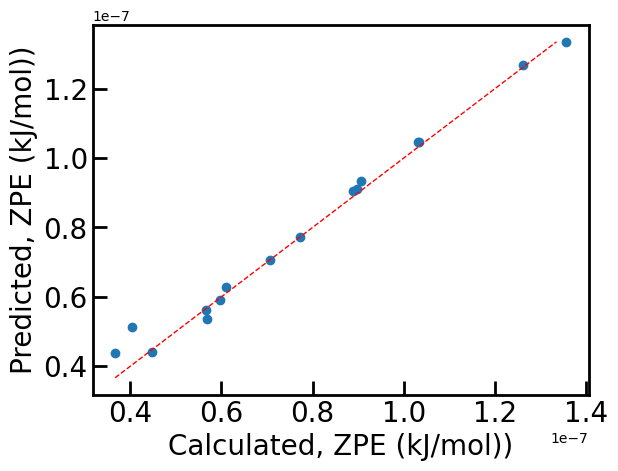

gpr5 0.9933498530943191
RMSE:  0.019243911627364524
RMSE unscaled:  2.3377936406553398e-09
----------------------------------------


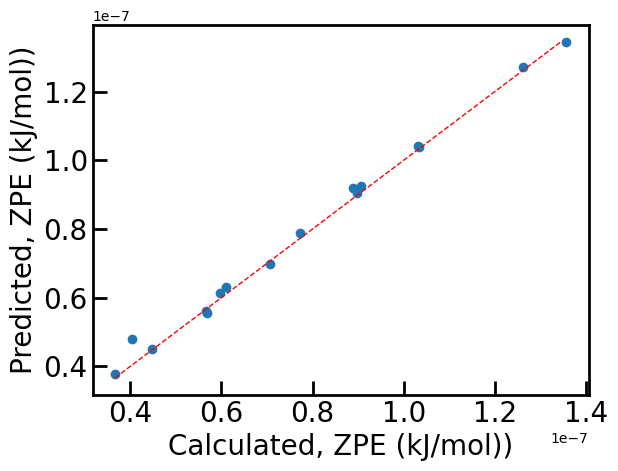

gpr6 0.9814204383088689
RMSE:  0.0321658821490762
RMSE unscaled:  3.907583665435788e-09
----------------------------------------


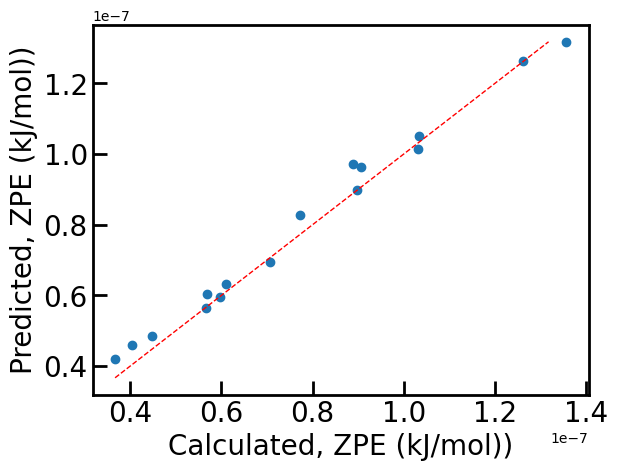

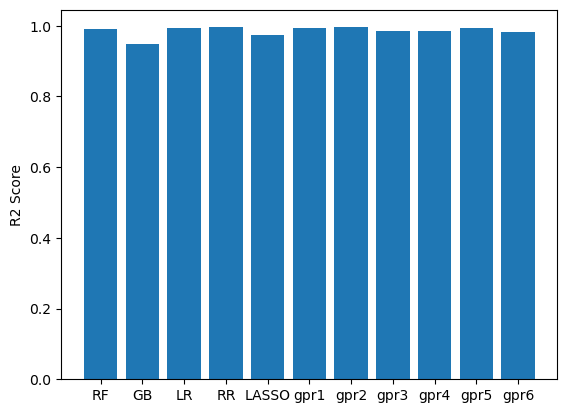

In [49]:
run_models()